In [1]:
from data_formatting import *
from architectures import UNET_IR
from training import *
from evaluation import *
import torch
import os
import datetime
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import pickle 
import pandas as pd
import numpy as np

Using device: cuda
Using device: cuda


In [57]:
#path_test = "D:\IR_blobs\IR_blobs_github\data_IR_final\localization\localization_test.csv"
#path_train = "D:\IR_blobs\IR_blobs_github\data_IR_final\localization\localization_train.csv"

In [58]:
df_test = pd.read_csv('localization_test.csv')
df_train = pd.read_csv('localization_train.csv')

In [59]:
collection_train = prepare_data_localization(df_train, sequence=False, seq_len=8)
collection_test = prepare_data_localization(df_test, sequence=False, seq_len=8)

In [61]:
collection_train[41004]

(array([[[19.79, 19.71, 17.03, 16.98, 17.23, 17.99, 17.08, 17.42],
         [19.42, 18.2, 17.49, 17.01, 17.39, 17.1, 17.27, 18.2],
         [16.75, 16.98, 17.07, 16.93, 17.16, 17.81, 18.01, 20.97],
         [16.86, 16.52, 16.9, 16.93, 17.0, 17.24, 18.66, 20.07],
         [16.58, 16.5, 16.9, 16.75, 16.69, 16.87, 16.9, 17.41],
         [16.27, 17.32, 16.92, 16.93, 16.69, 17.19, 16.71, 16.57],
         [17.29, 18.23, 17.34, 15.98, 16.69, 16.6, 16.26, 16.08],
         [20.02, 18.17, 15.93, 15.79, 15.7, 16.46, 15.8, 15.6]]],
       dtype=object),
 array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]]))

In [62]:
len(collection_train)

11058

In [63]:
interpolate = False
window_size = 8
path_to_save = "D:/IR_blobs/IR_blobs_github/models"

In [64]:
train_set, test_set = create_datasets(collection_train, collection_test)

In [65]:
len(train_set)

42715

In [66]:
batch_size = 64
num_epochs = 500
interpolate = False
dim_dim = [16, 32]
std = 0.001
patience = 20
learning_rate = 0.0004
code_word = f"unet_{dim_dim[0]}_{dim_dim[1]}_len{window_size}__std{std}_lr{learning_rate}_pt{patience}"

In [67]:
train_loader = dataset_to_loader(train_set, batch_size, balancing = False, shuffle = True)
test_loader = dataset_to_loader(test_set, 1, balancing = False, shuffle = False)

In [68]:
len(train_loader)

668

In [16]:
#model = CLSTM_UNET_tiny(features=dim_dim, hidden_dims=dim_dim, incl_botneck = False)
model = UNET_IR(features=dim_dim)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNET_IR(
  (ups): ModuleList(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, a

In [17]:
criterion = FocalLoss(alpha = 0.8, gamma = 4.0, reduction = 'sum').to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 117313


In [19]:
for frames, labels in train_loader:
    print(frames.shape, labels.shape)
    print(frames[1], labels[1])
    # Process the frames and labels
    break 

torch.Size([64, 1, 8, 8]) torch.Size([64, 8, 8])
tensor([[[17.2000, 17.2500, 18.7900, 18.8500, 17.3200, 17.7500, 17.1600,
          17.3000],
         [16.6900, 16.9500, 18.3200, 18.3900, 17.6800, 17.1500, 17.3800,
          17.3400],
         [17.7500, 17.1800, 17.2200, 16.9800, 17.4100, 17.7900, 17.0700,
          17.4300],
         [20.2100, 19.0300, 17.1700, 17.0200, 17.0400, 17.2500, 17.5900,
          17.3500],
         [19.5900, 18.1600, 17.2900, 17.1000, 17.5300, 17.3900, 17.0200,
          17.2100],
         [17.0000, 17.2100, 17.1200, 16.9500, 17.7600, 17.7700, 17.0500,
          16.3900],
         [16.2600, 16.3700, 16.7800, 16.3800, 19.3200, 19.3100, 16.9200,
          16.0500],
         [16.9200, 16.1600, 15.7600, 16.6100, 16.9800, 18.9700, 16.7900,
          15.8100]]]) tensor([[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 

In [21]:
run = 1
code_word = f"clstm_unet_8_16_len{window_size}_shrink_std{std}_lr{learning_rate}_pt{patience}_run{run}"
#noise002_learningrate0004_length8_16_32_shrink
model, loss_batch, loss_epoch, learniung_rate_list = network_training_detect(model, train_loader, criterion, optimizer, num_epochs, code_word, path_to_save, interpolate = False, sequence = False, add_noise = True, patience = patience, std = std)

current learning rate:0.0004
EPOCH 0: Accuracy: 0.9828
Recall: 0.5107581615447998 
tp: 48236, fn: 46204, fp: 885, tn: 2638435
Epoch loss: 0.13192557858510973
EPOCH 1: Accuracy: 0.9910
Recall: 0.7478928565979004 
tp: 70631, fn: 23809, fp: 768, tn: 2638552
Epoch loss: 0.04940399135511234
EPOCH 2: Accuracy: 0.9927
Recall: 0.7957645058631897 
tp: 75152, fn: 19288, fp: 695, tn: 2638625
Epoch loss: 0.04047089157765355
EPOCH 3: Accuracy: 0.9934
Recall: 0.8160737156867981 
tp: 77070, fn: 17370, fp: 667, tn: 2638653
Epoch loss: 0.03711960314448483
EPOCH 4: Accuracy: 0.9940
Recall: 0.8332592248916626 
tp: 78693, fn: 15747, fp: 615, tn: 2638705
Epoch loss: 0.03387921545107276
EPOCH 5: Accuracy: 0.9943
Recall: 0.8427785038948059 
tp: 79592, fn: 14848, fp: 638, tn: 2638682
Epoch loss: 0.032553682915572466
EPOCH 6: Accuracy: 0.9948
Recall: 0.8549237847328186 
tp: 80739, fn: 13701, fp: 644, tn: 2638676
Epoch loss: 0.029935990187263065
EPOCH 7: Accuracy: 0.9950
Recall: 0.8618276119232178 
tp: 81391, f

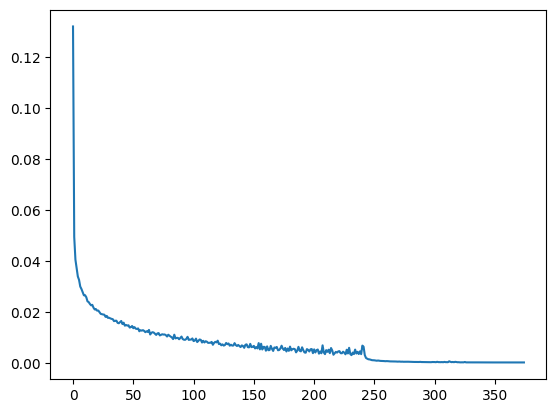

In [22]:
plt.plot(loss_epoch)

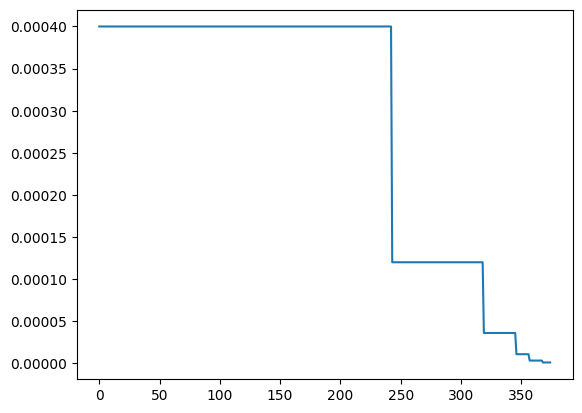

In [23]:
plt.plot(learning_rate_list)

In [50]:
model.load_state_dict(torch.load(f'{path_to_save}/model_{code_word}.pt'))

<All keys matched successfully>

In [51]:
pixel_accuracy, pixel_recall, pixel_precision, image_level_accuracy, image_level_accuracy_relaxed, tolerable_ratio, misclassified_samples, mis_idxs = evaluation_of_detection_joint(model, test_loader, device, margin_of_error=0, interpolate=False, temp_threshold=0.5, sequence = False, slack = 1)

Pixel-Level Accuracy: 0.9983142860372581
Pixel-Level Recall: 0.9716832234704299
Pixel-Level Precision: 0.9729026260748315
Image-Level Accuracy: 0.9313619099294629
Image-Level Accuracy Relaxed: 0.9624706095134744
% tolerable examples with only 1 fp: 0.01564478205823838


## Checking misclassified

In [52]:
len(misclassified_samples)

415

In [53]:
misclassified_samples[1]

(918,
 0,
 tensor([[16.2600, 16.1100, 16.5600, 16.5200, 16.9700, 17.0200, 16.6900, 17.1100],
         [16.0300, 16.4000, 16.4200, 16.7600, 16.8700, 16.7500, 16.5900, 17.3300],
         [16.5100, 16.1300, 16.4500, 16.6400, 16.8000, 16.9400, 16.3400, 17.1600],
         [16.1300, 16.2700, 16.5400, 16.7500, 16.5700, 16.4700, 17.0800, 16.7100],
         [15.8400, 16.1000, 16.6600, 16.1900, 16.5900, 16.6200, 16.4800, 16.7700],
         [15.8400, 16.3900, 16.1600, 16.4800, 16.5000, 16.7500, 16.0400, 15.8000],
         [14.9400, 15.5900, 15.8700, 15.3600, 16.4000, 16.2900, 15.7100, 15.6900],
         [15.6100, 15.2800, 15.1800, 15.6800, 15.7100, 16.2300, 15.3800, 15.1400]]),
 tensor([[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, Fals

In [54]:
a = 100
b = 200

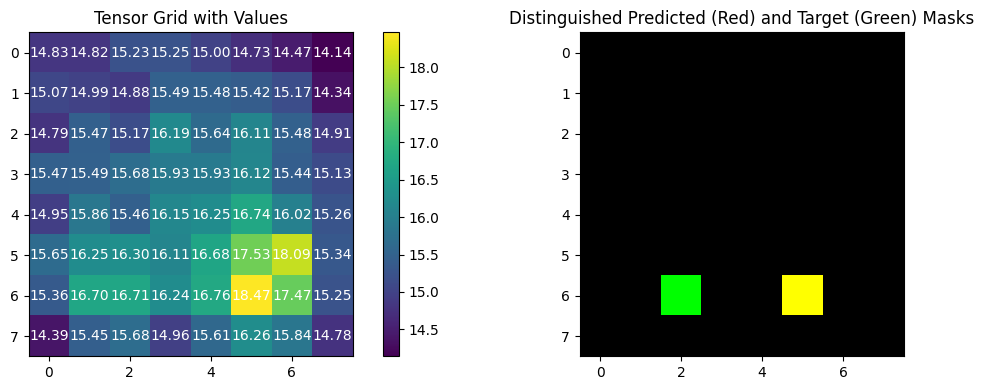

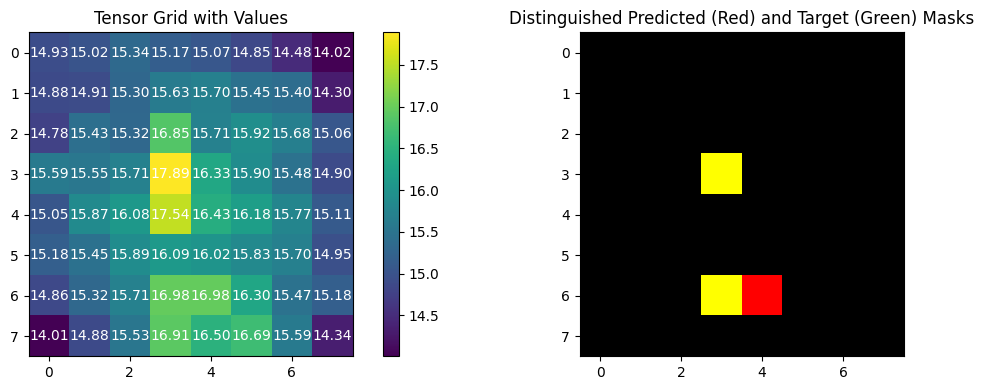

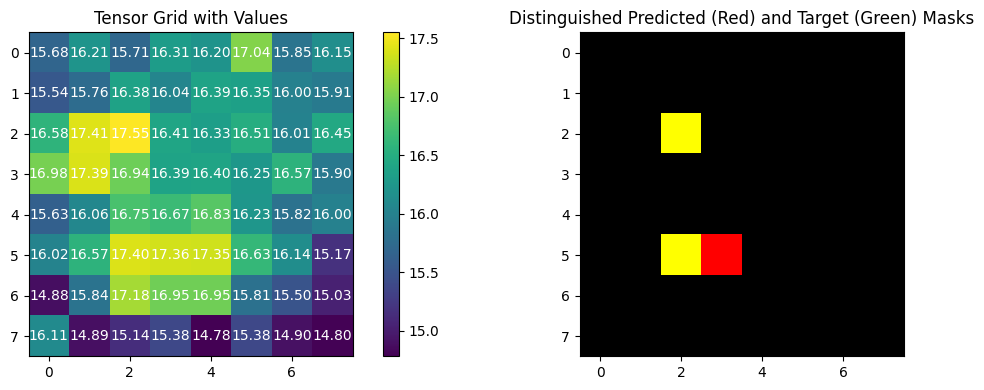

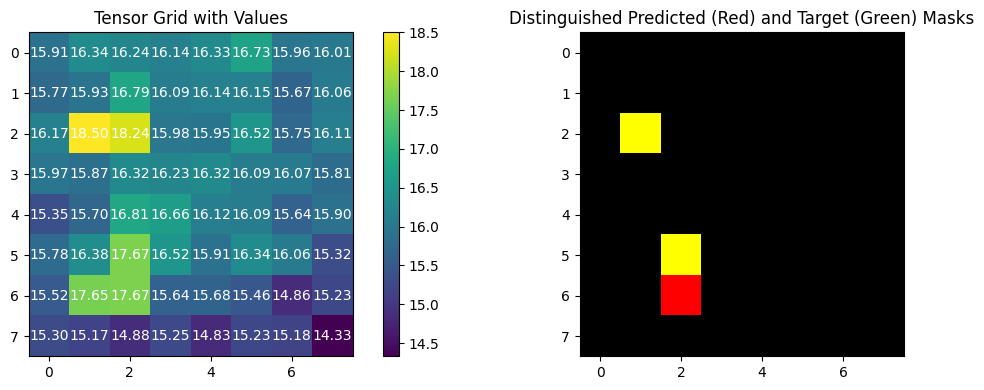

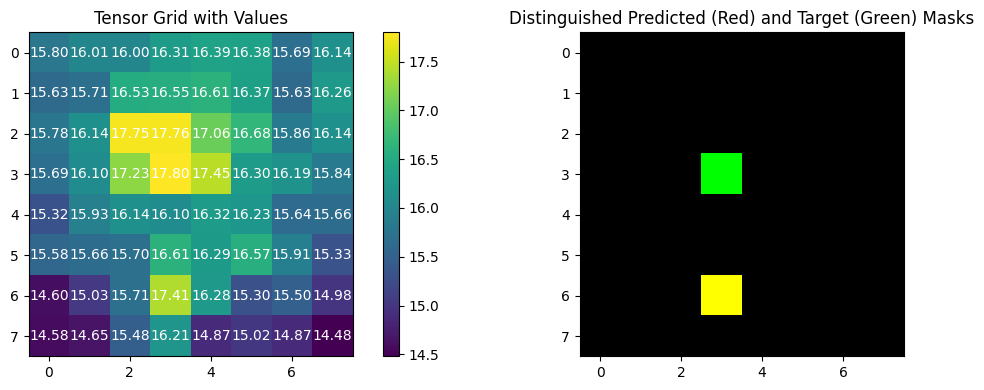

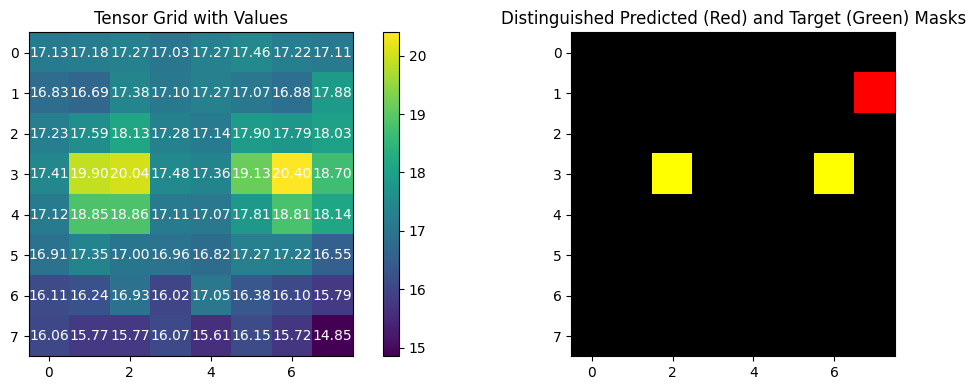

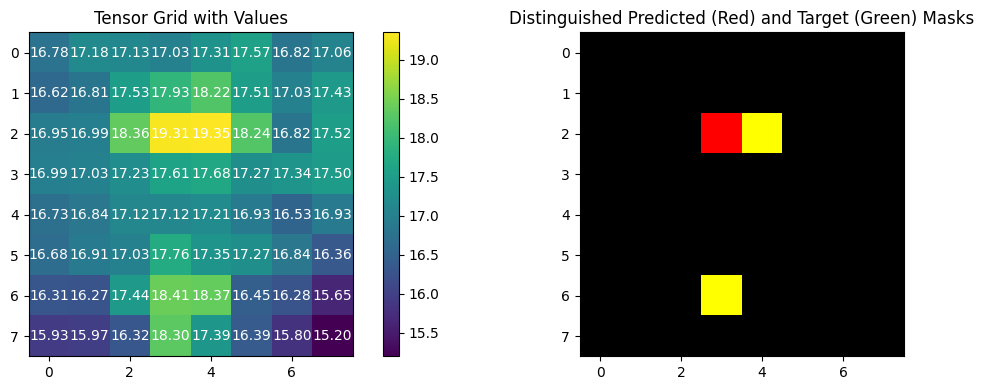

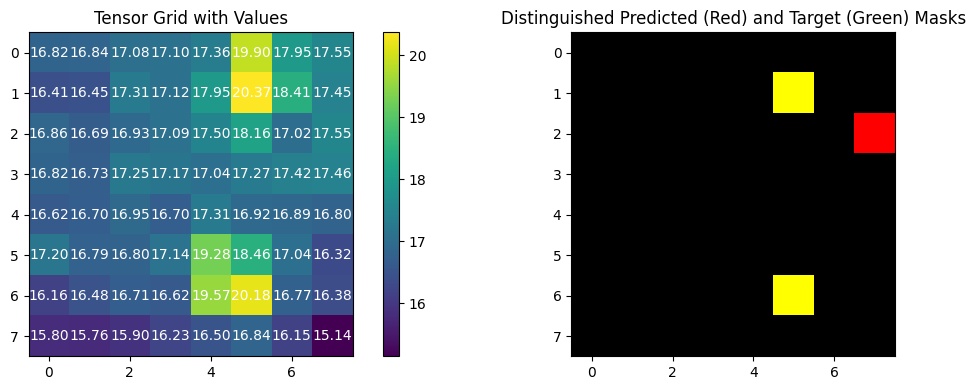

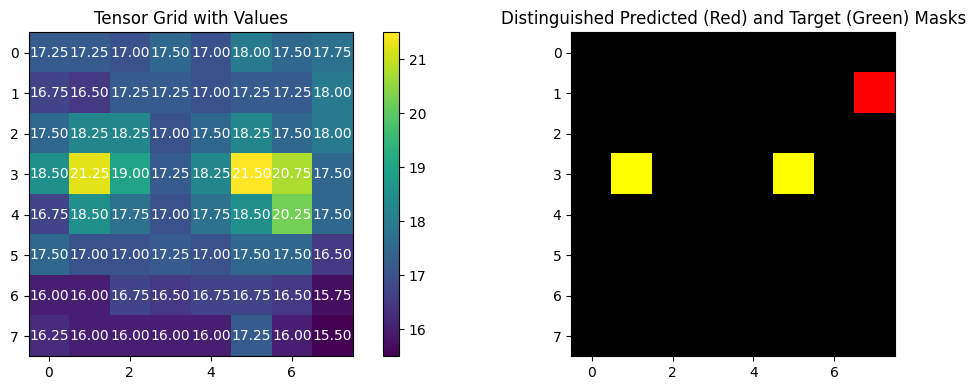

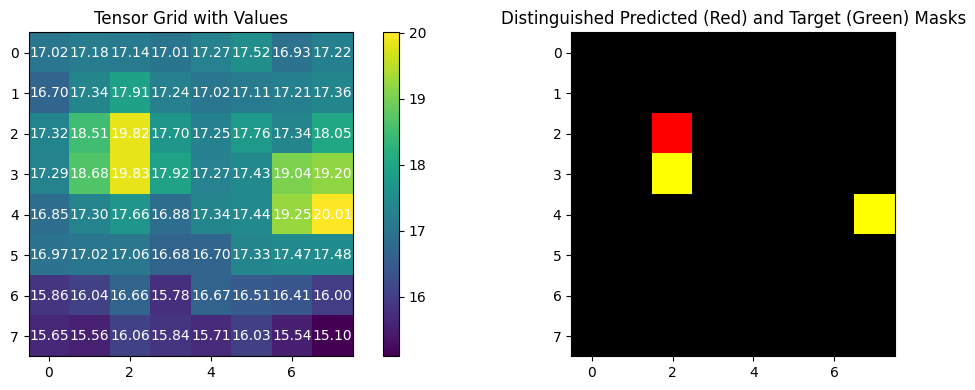

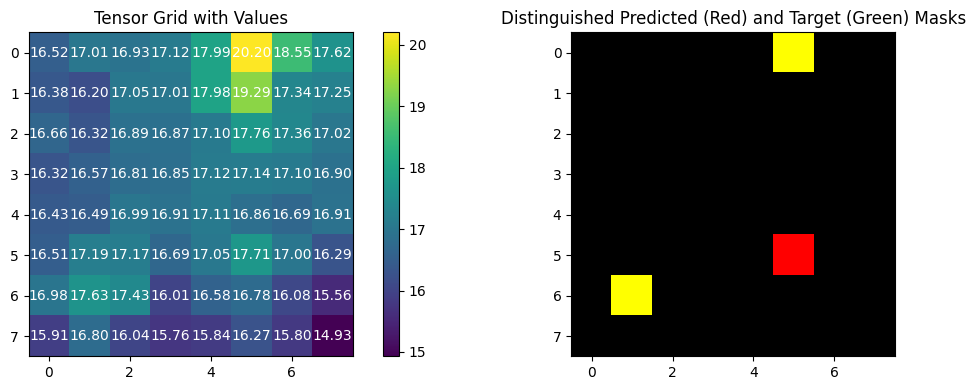

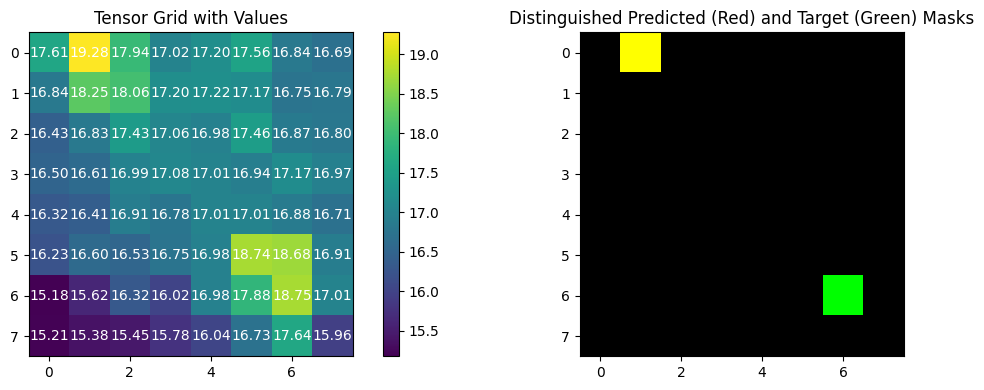

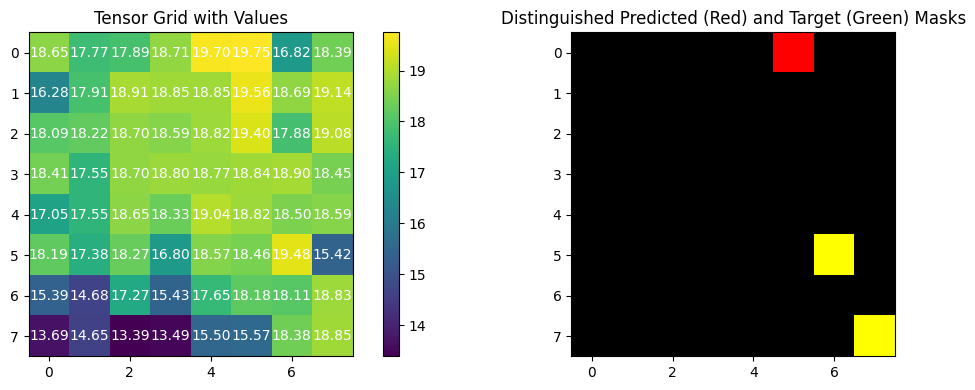

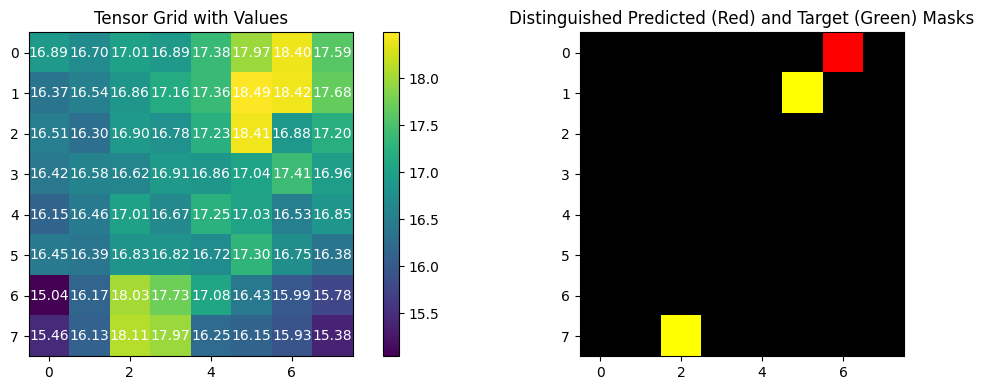

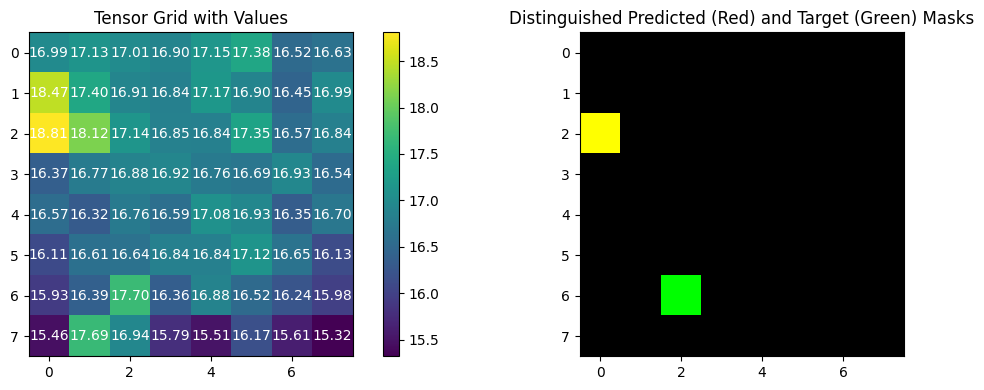

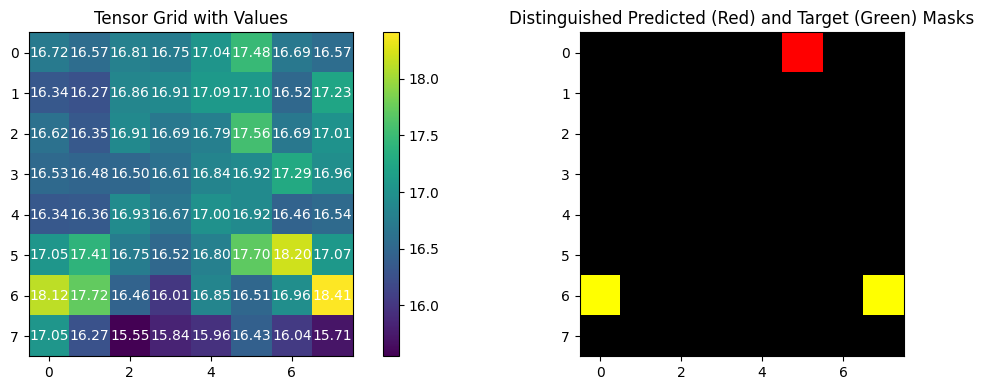

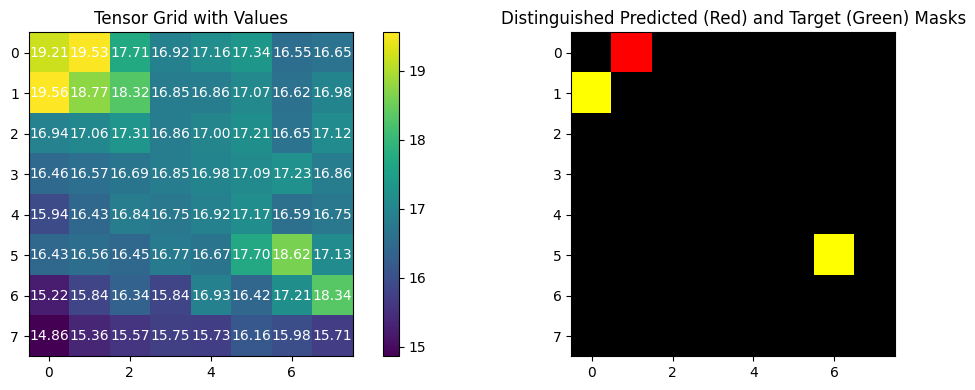

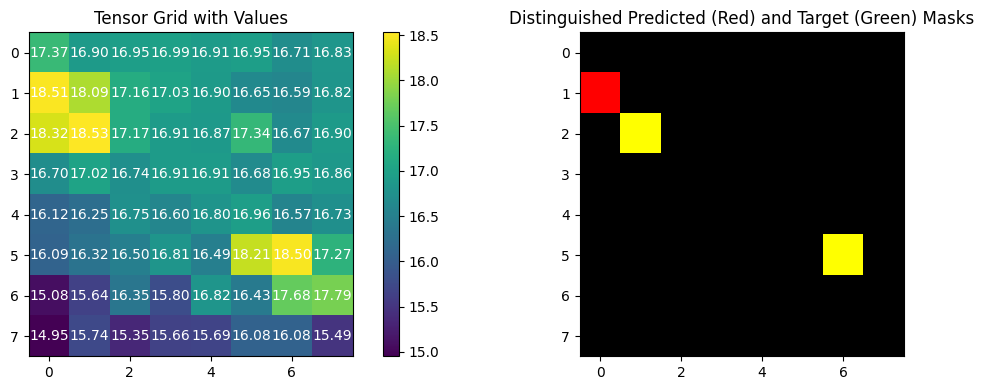

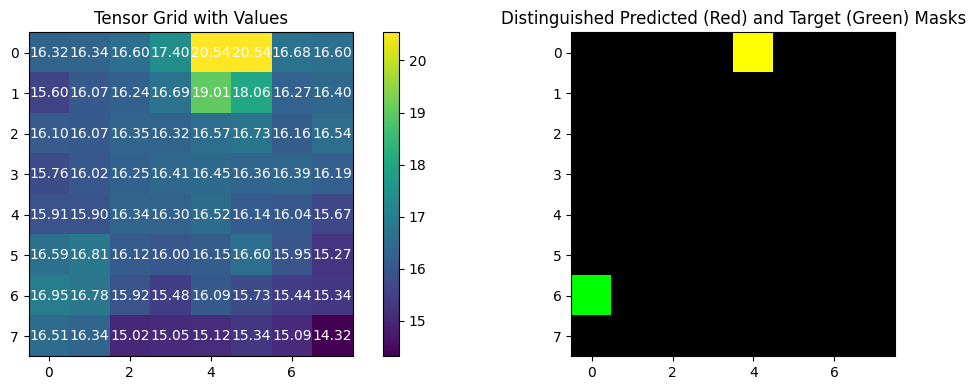

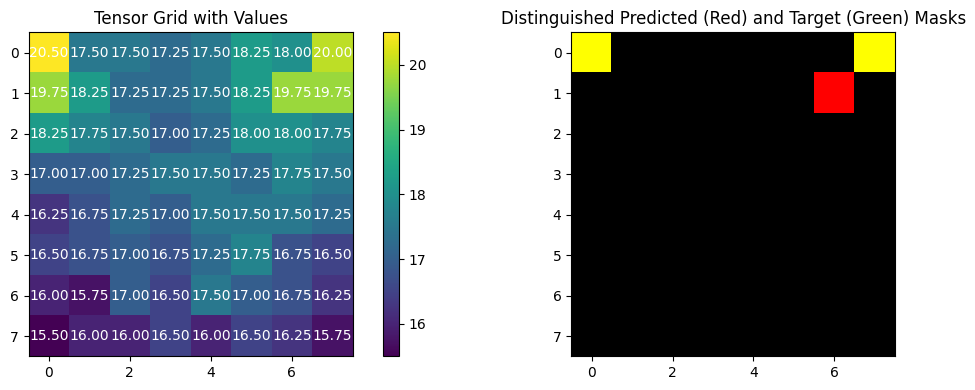

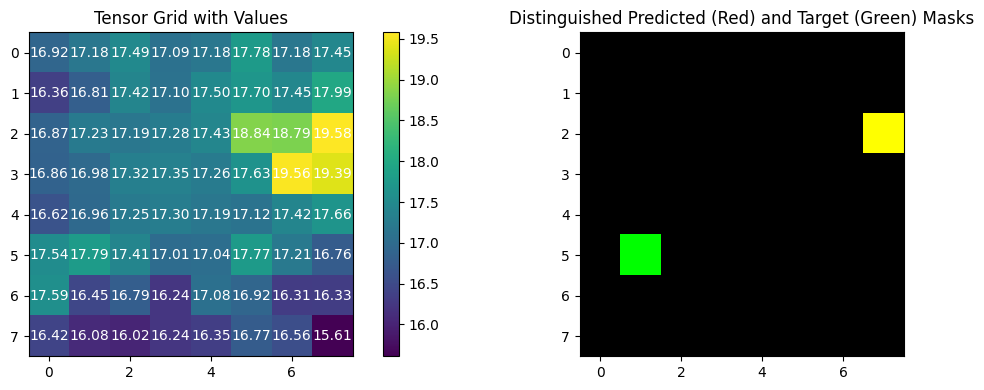

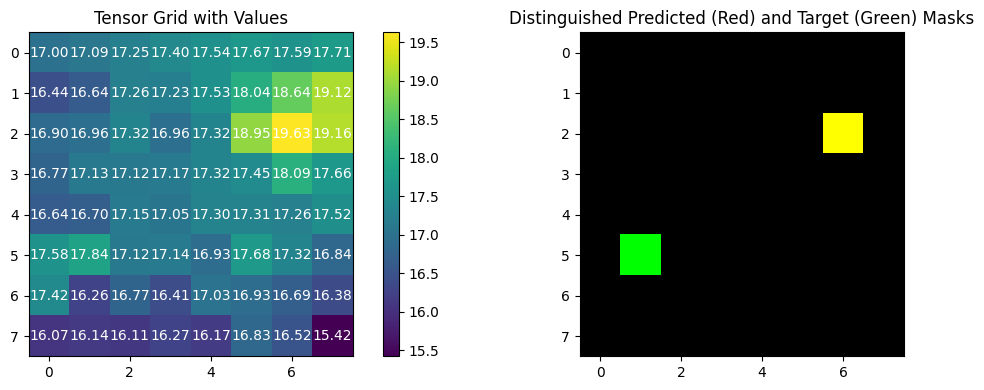

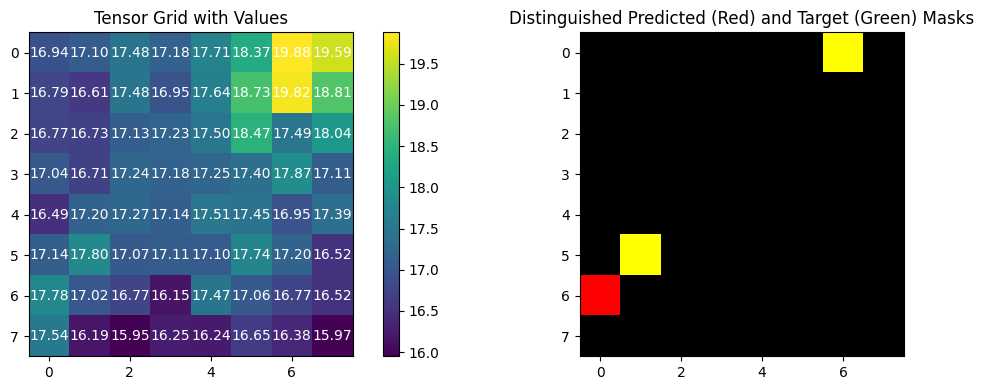

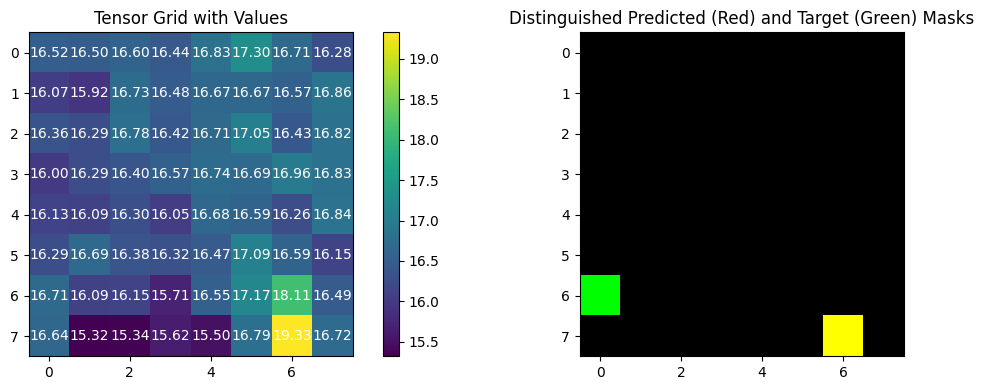

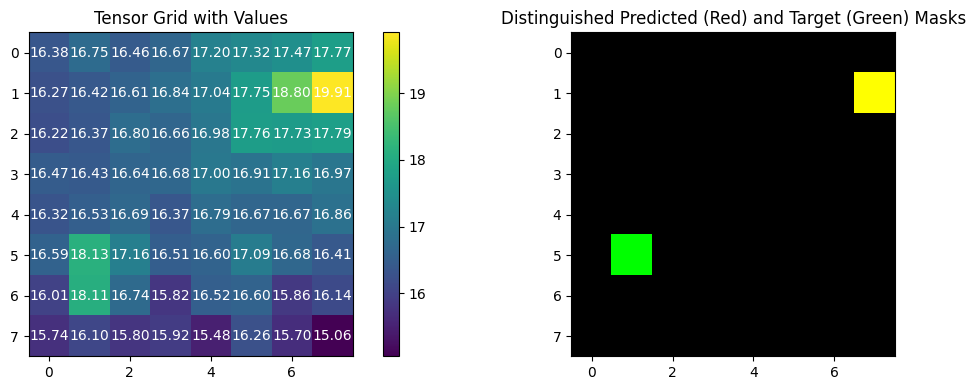

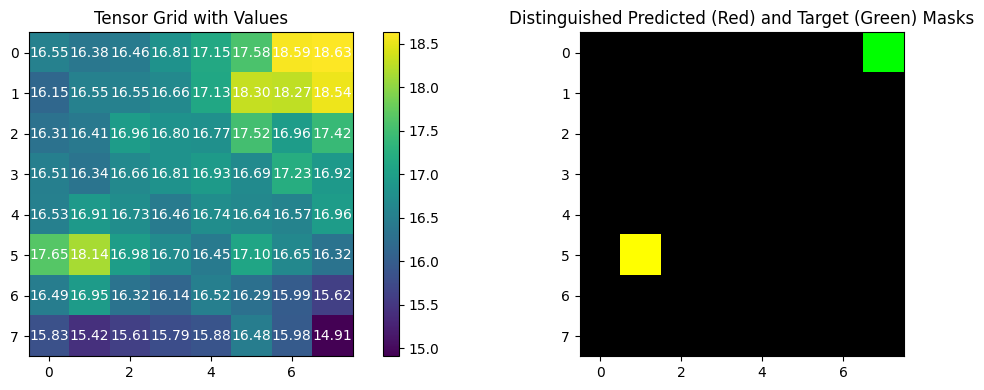

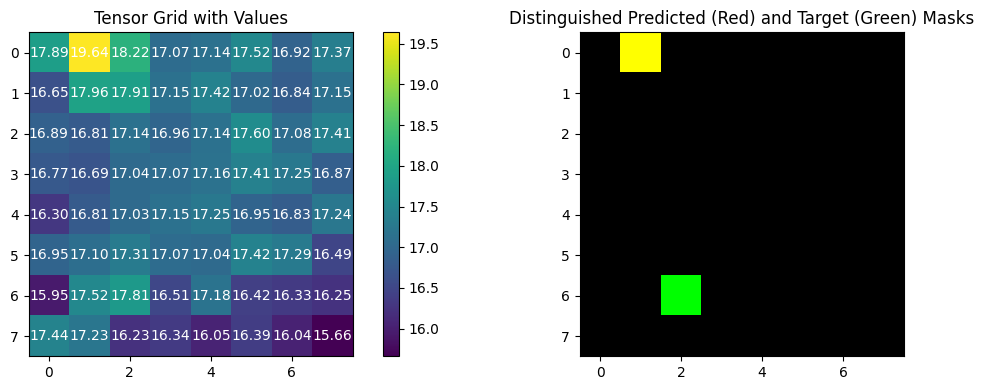

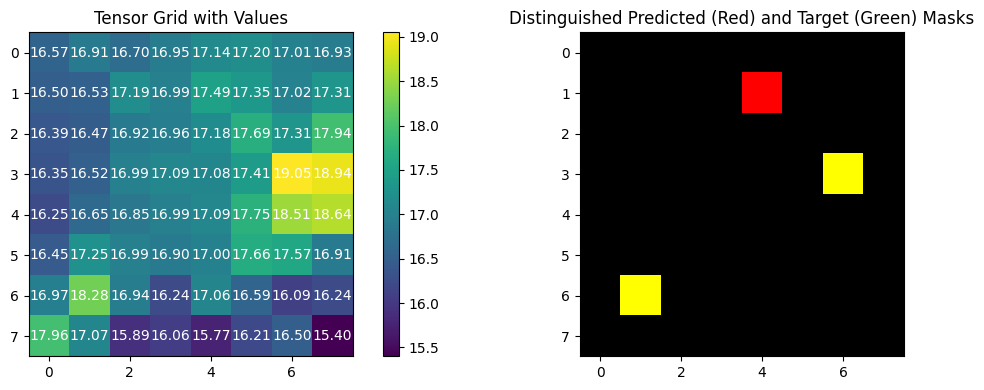

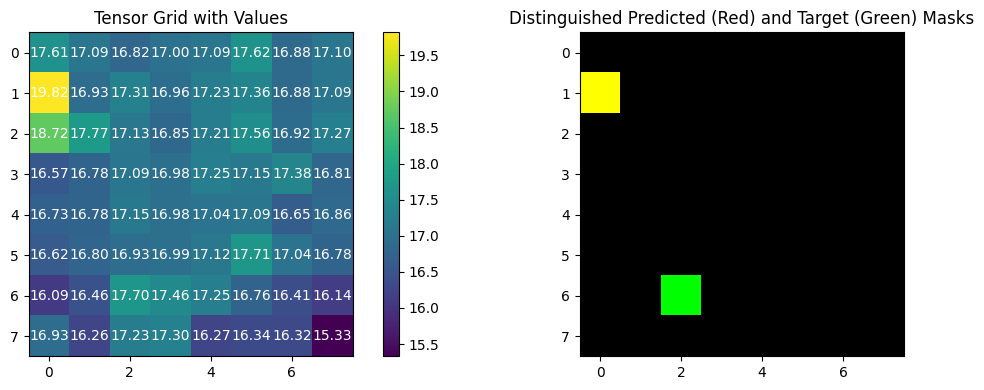

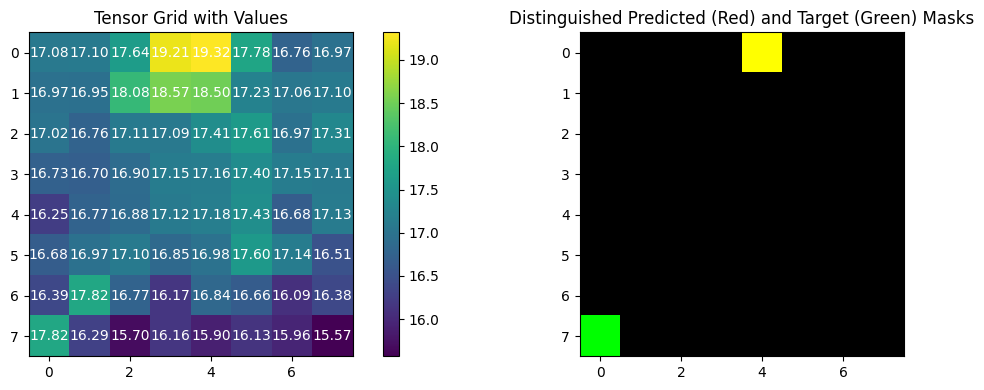

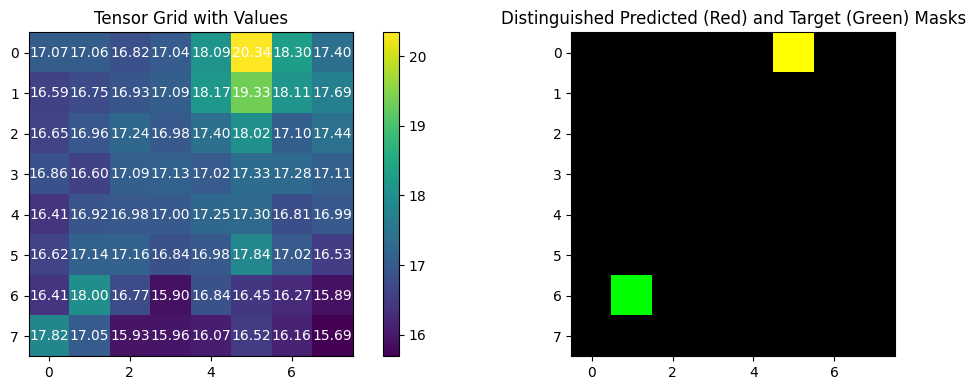

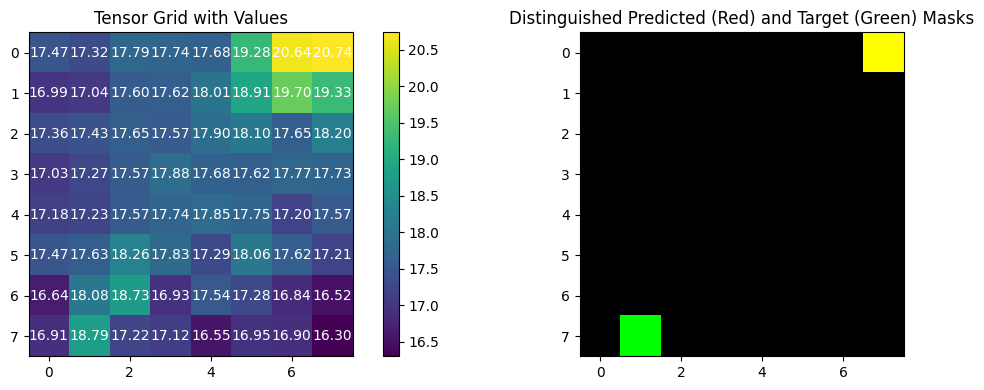

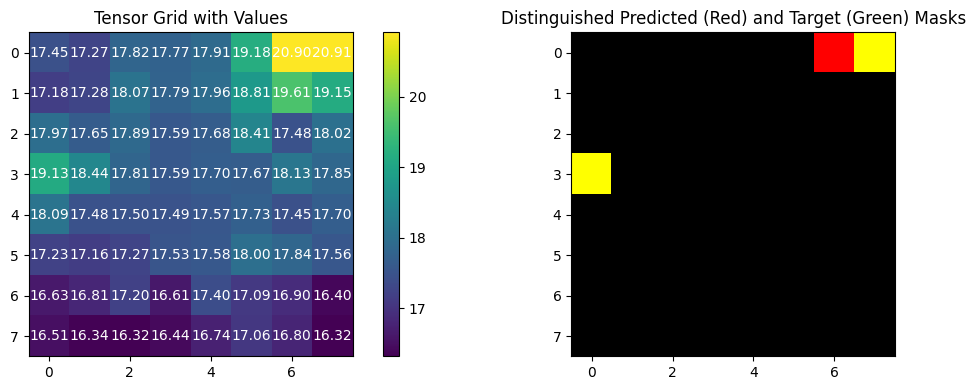

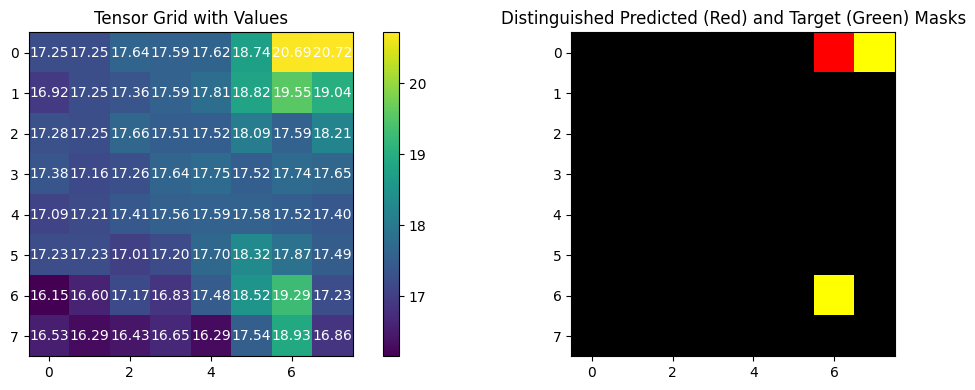

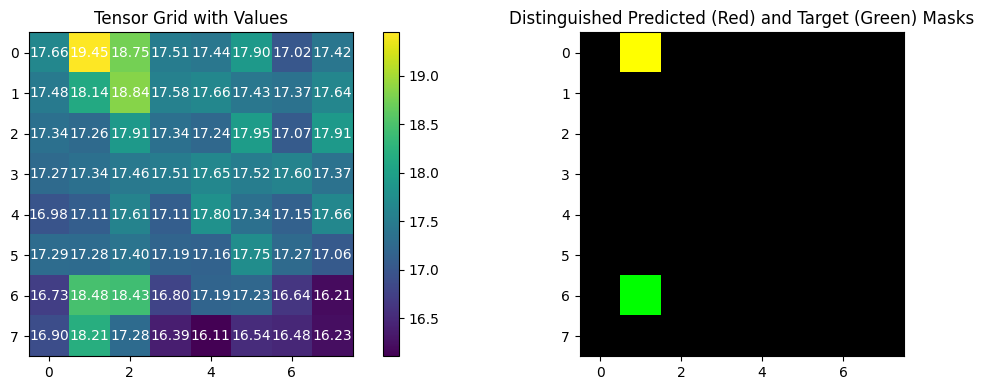

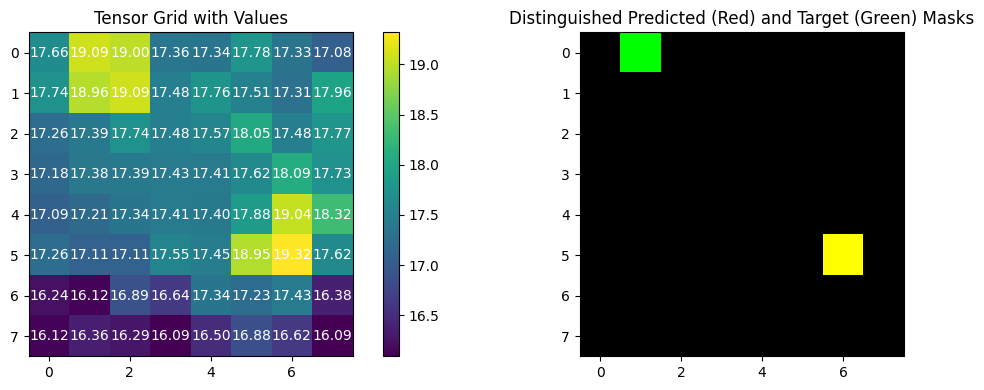

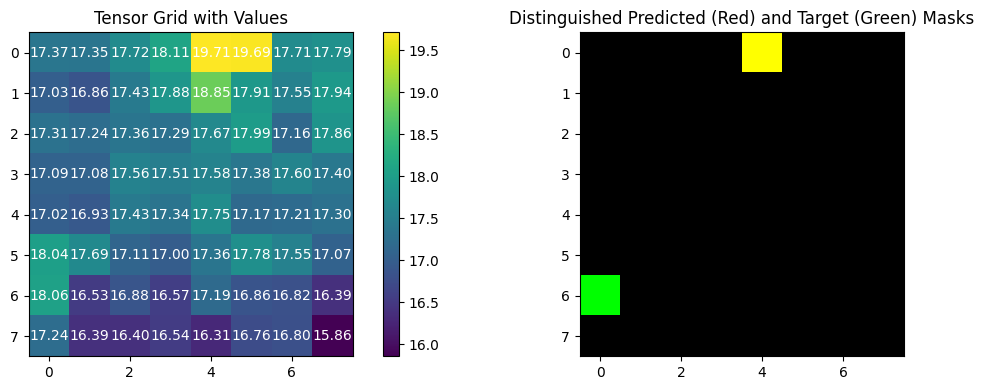

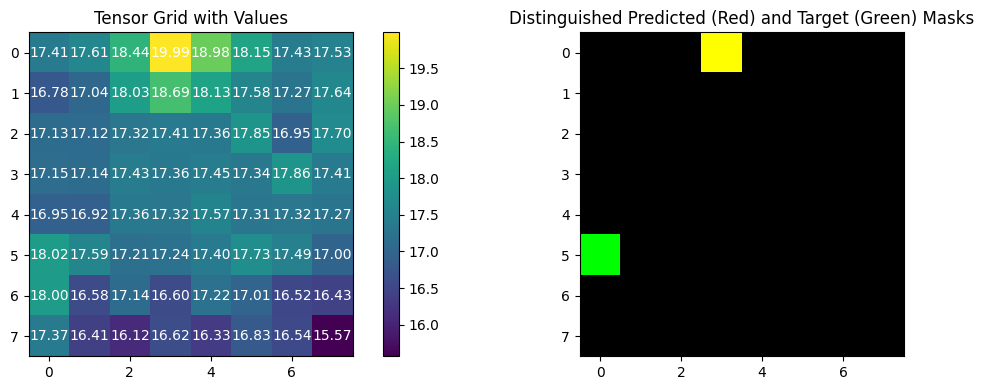

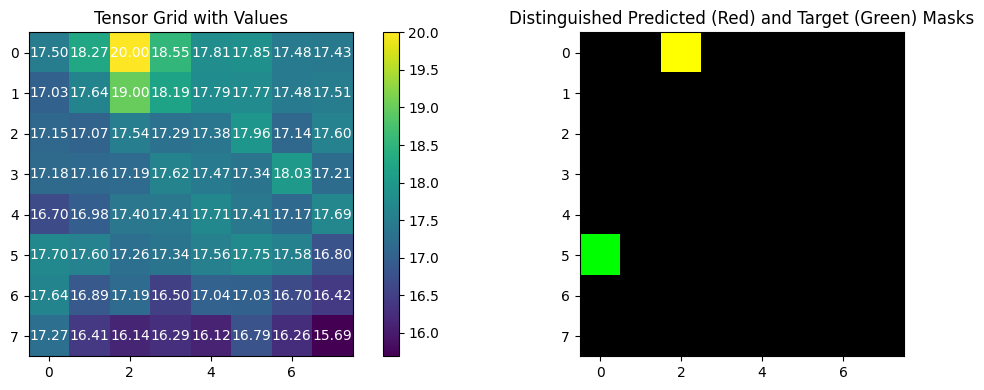

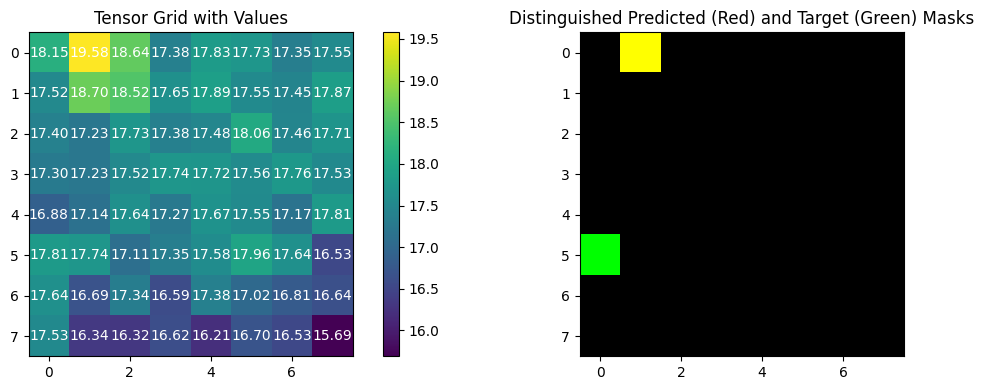

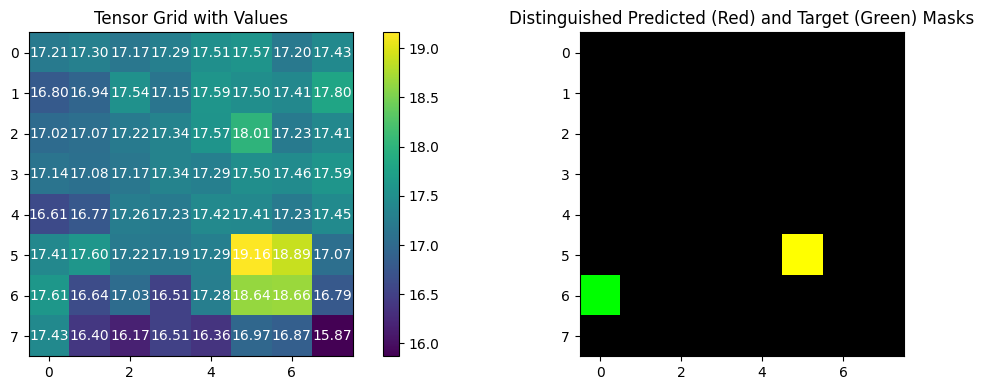

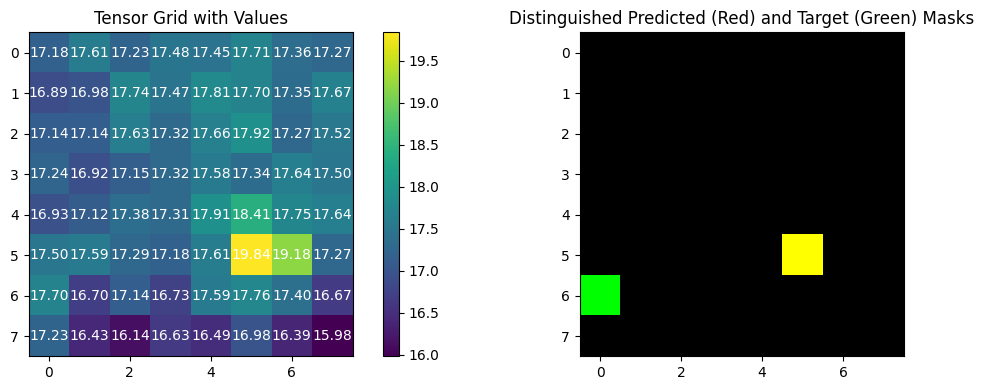

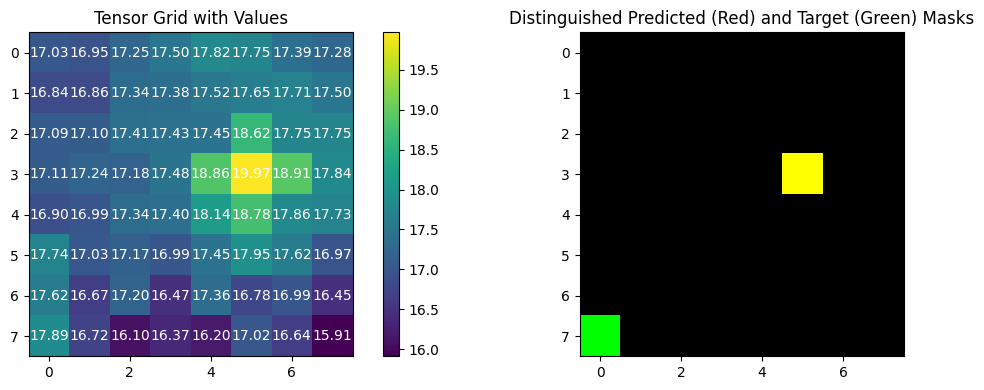

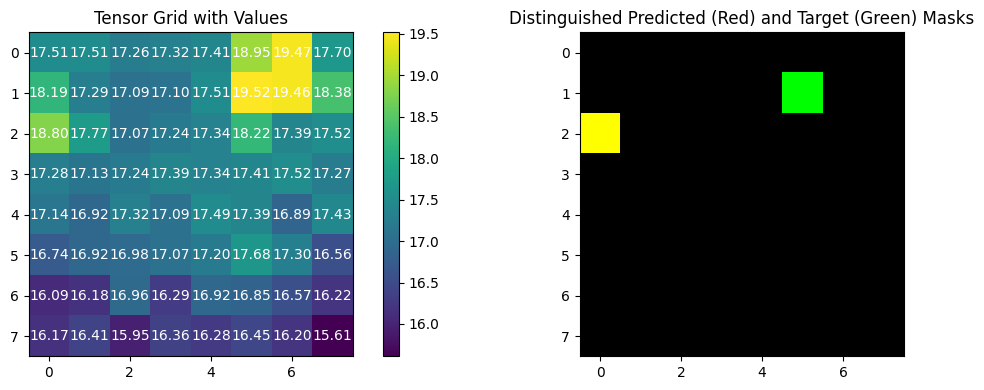

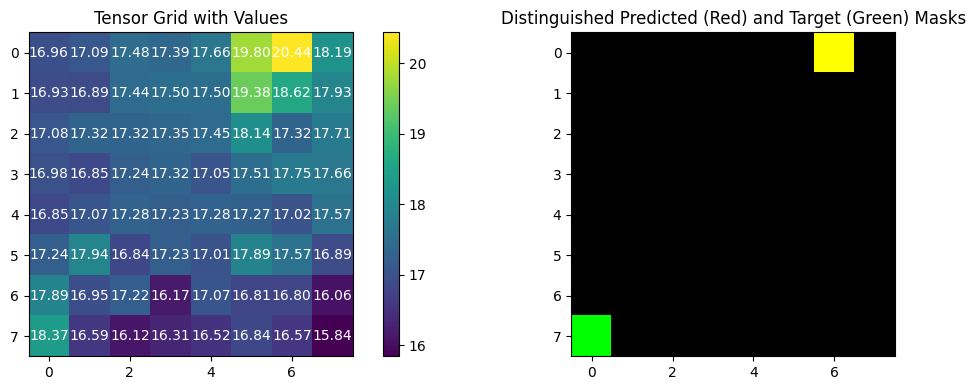

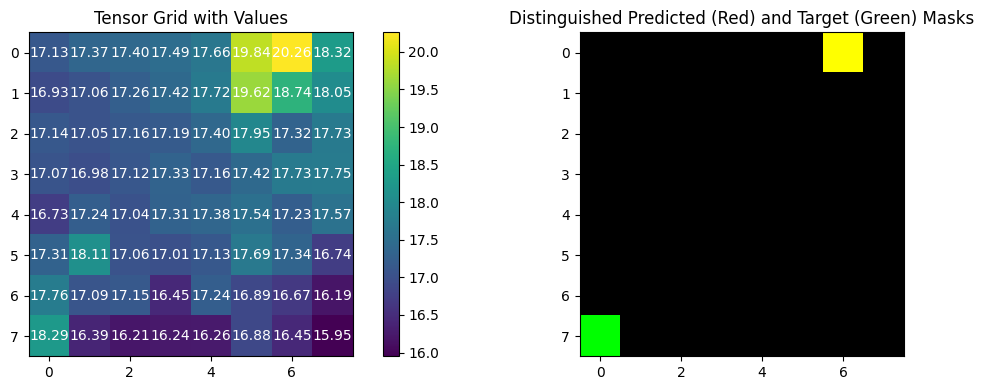

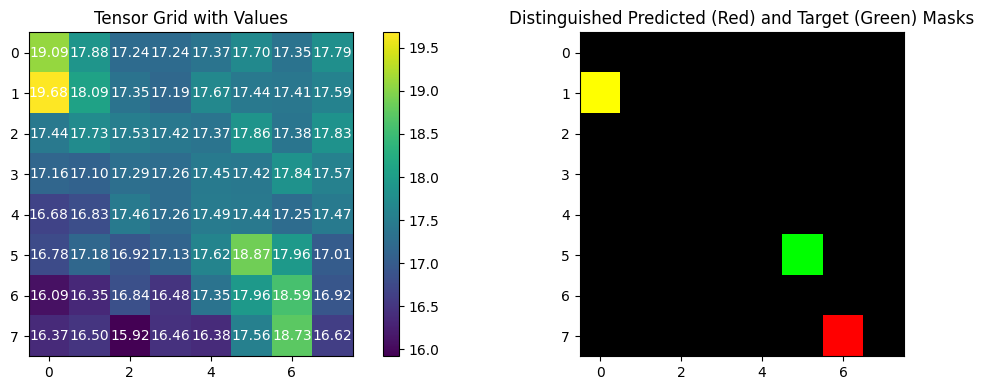

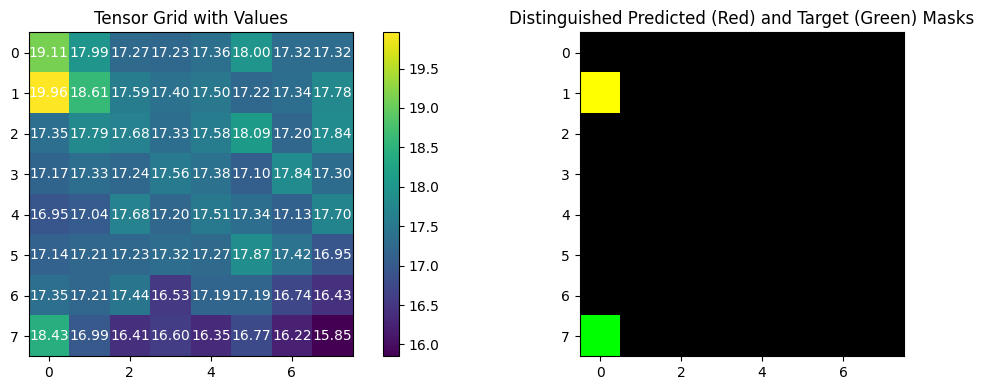

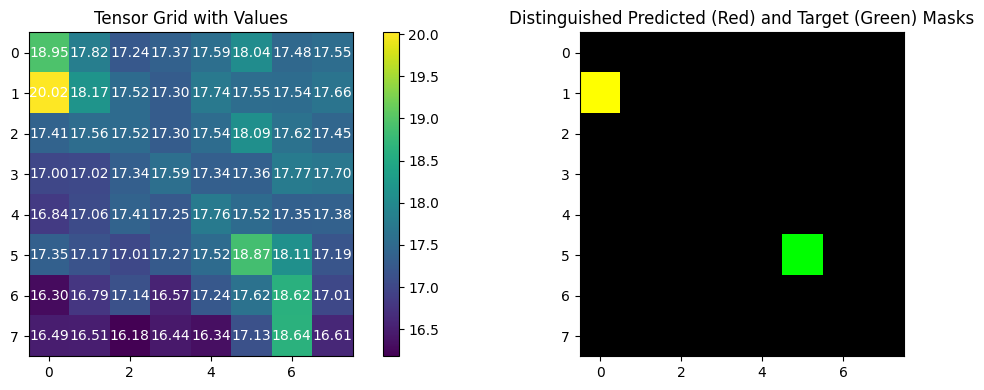

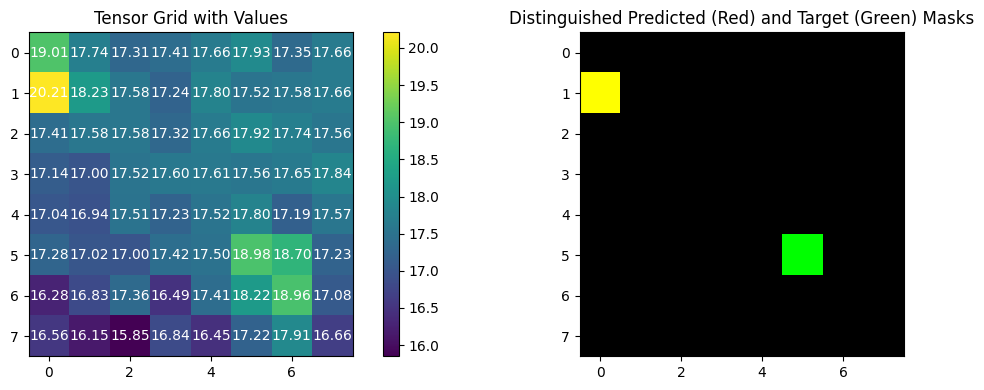

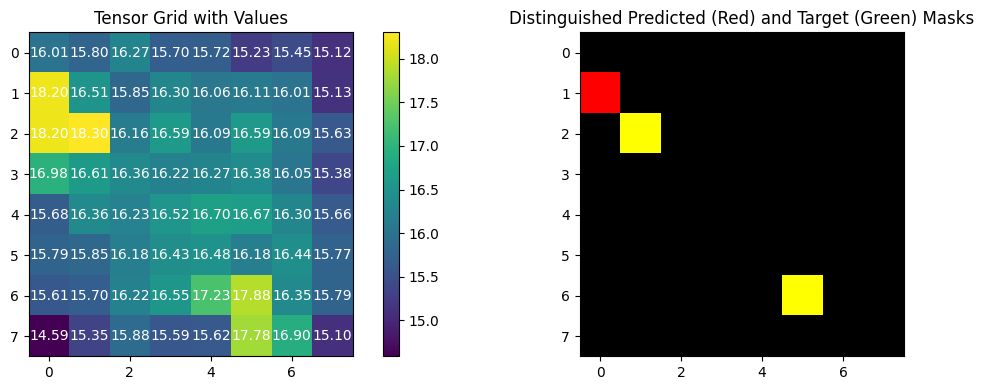

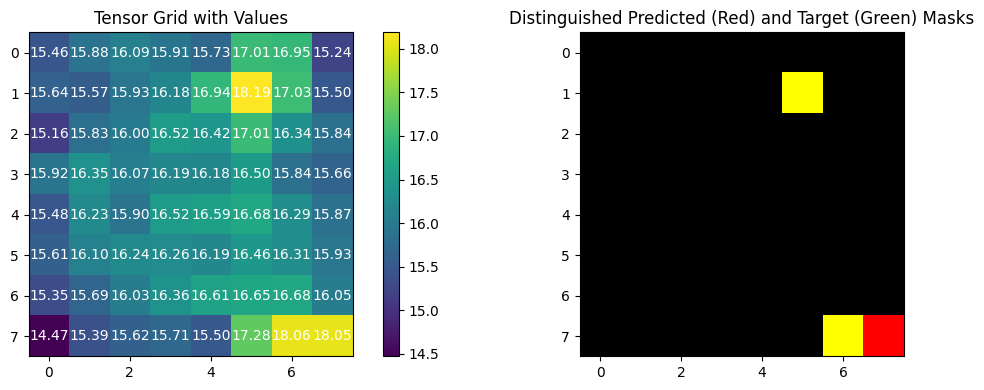

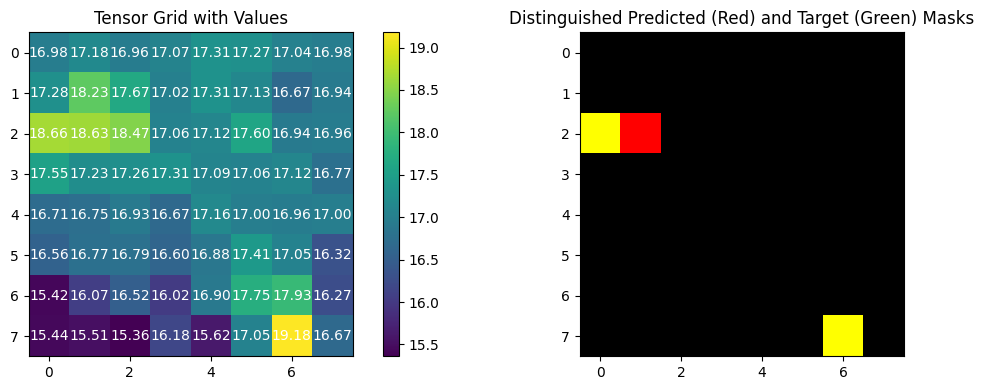

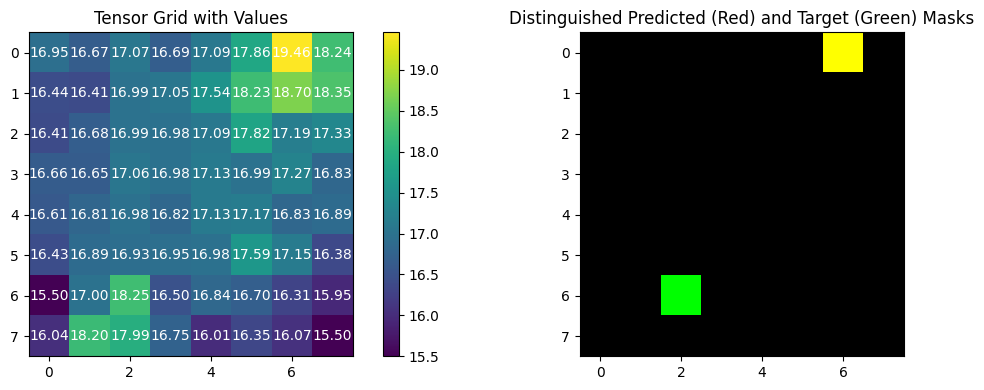

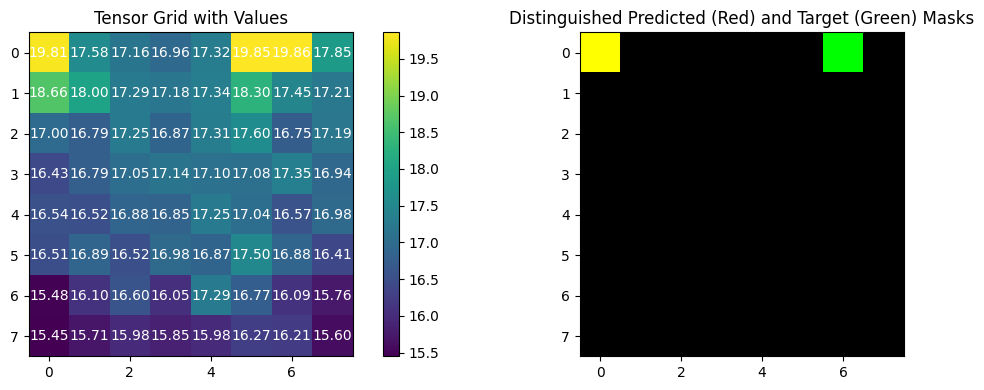

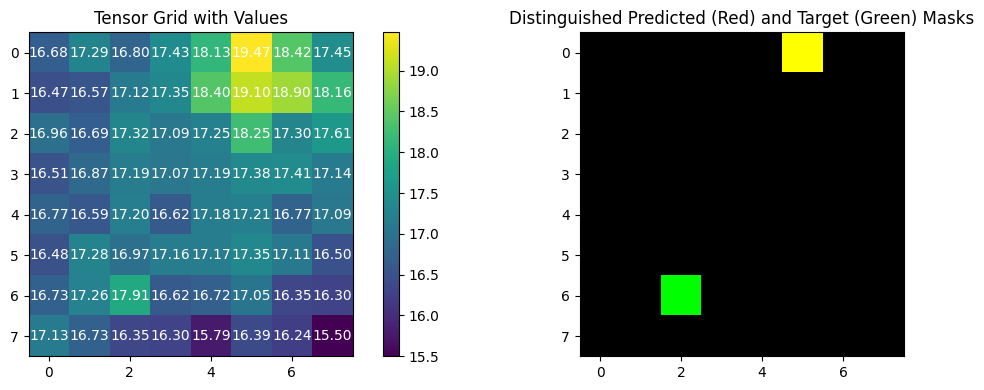

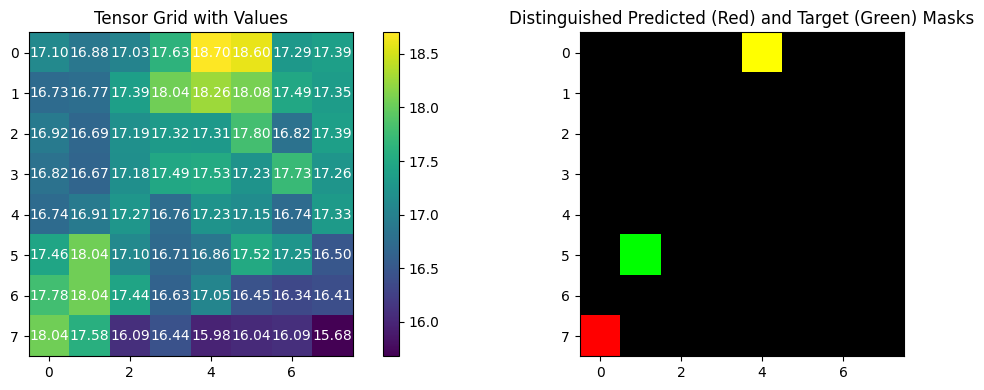

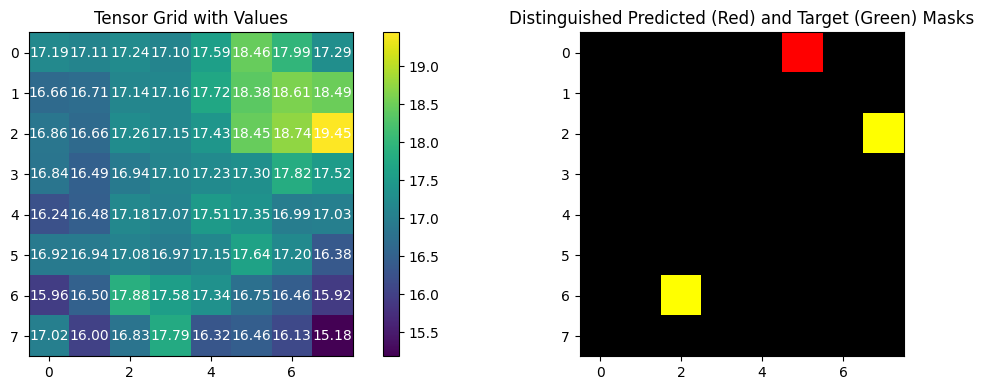

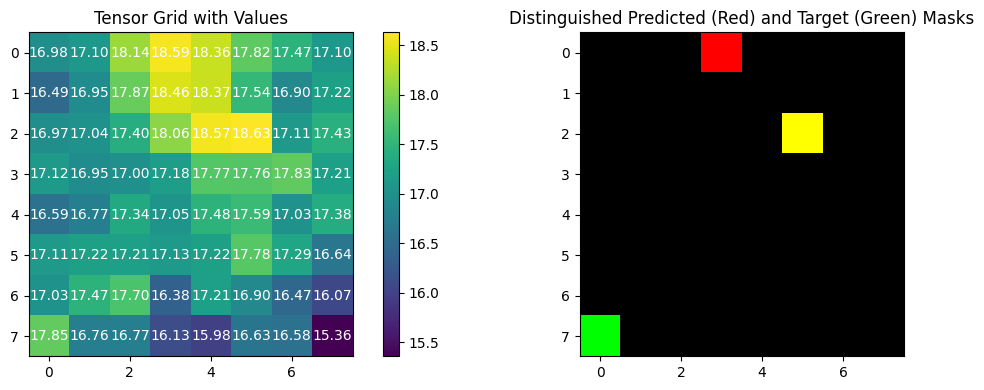

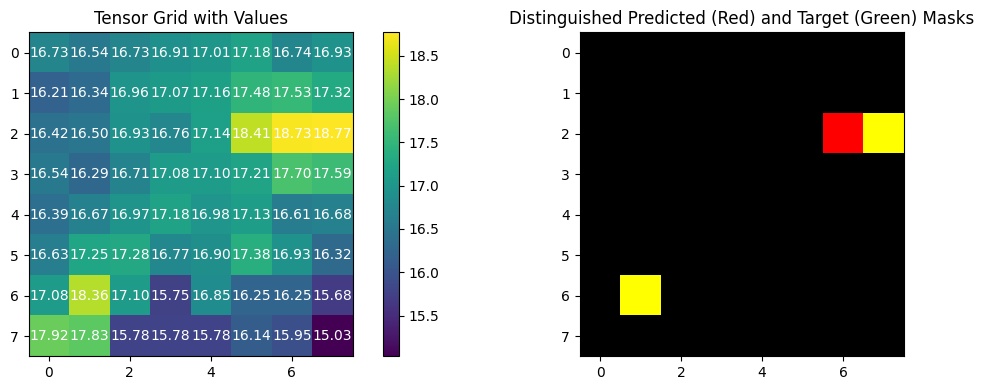

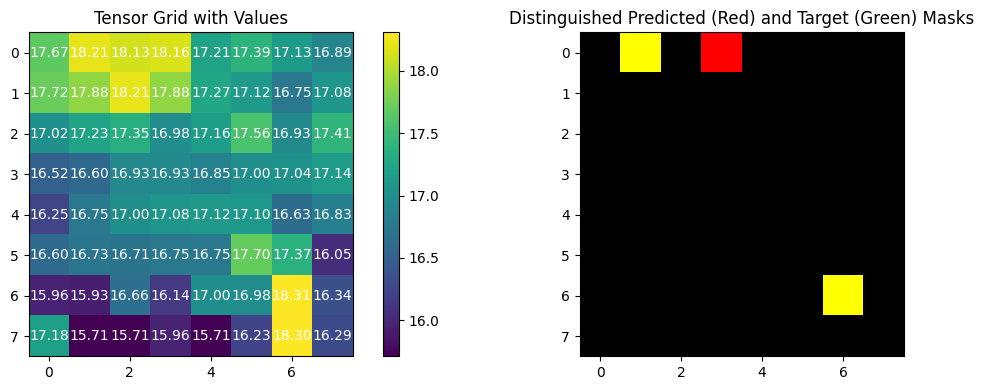

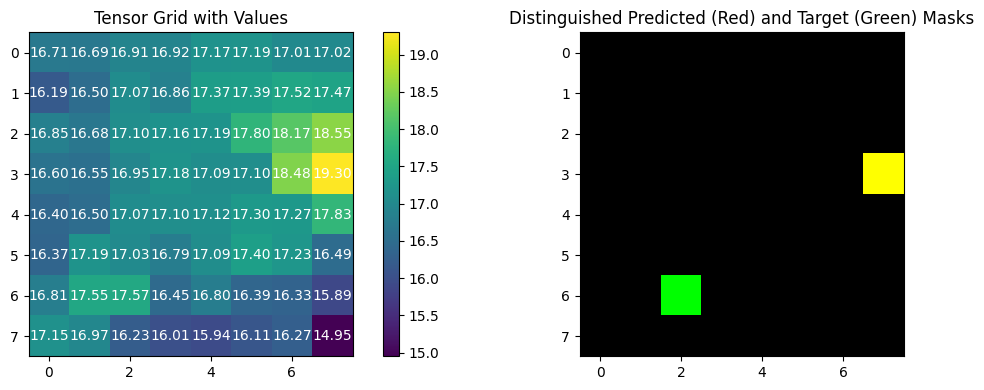

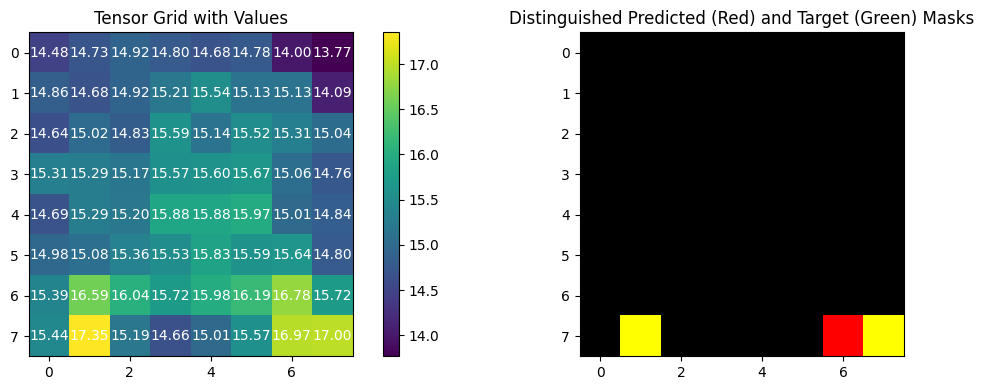

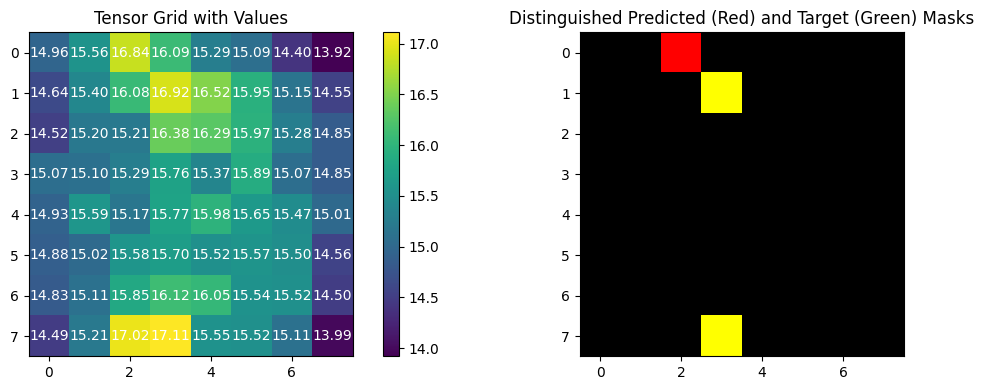

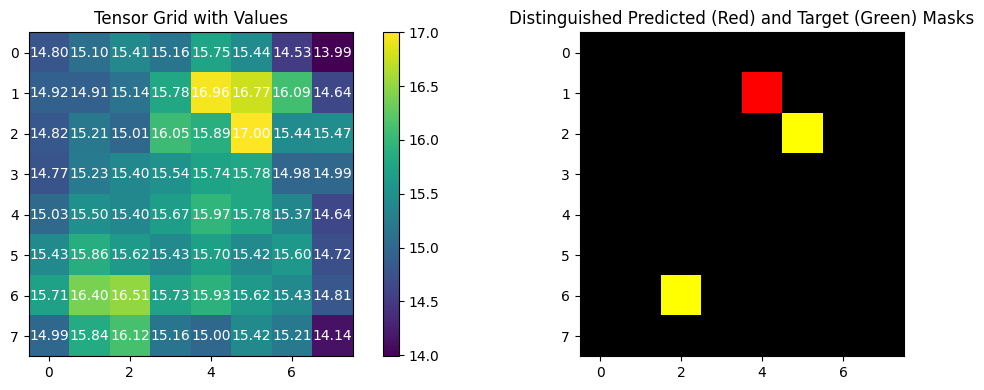

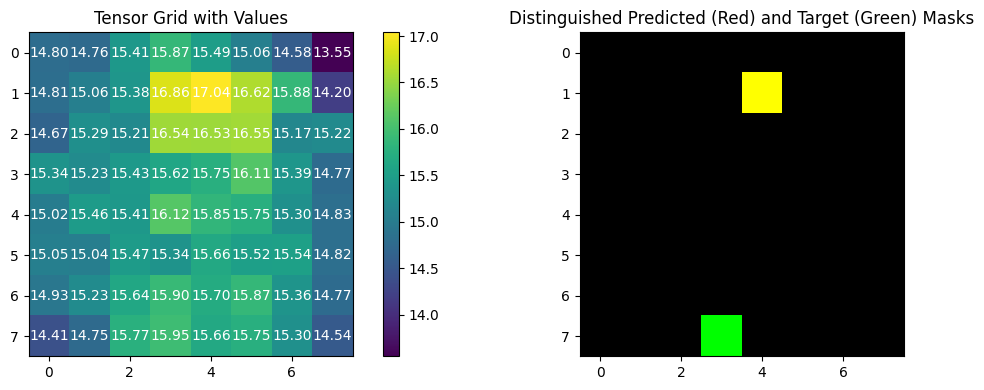

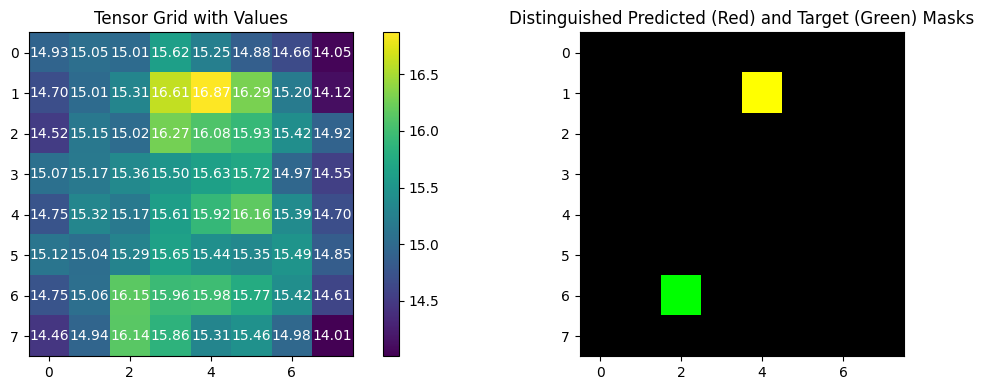

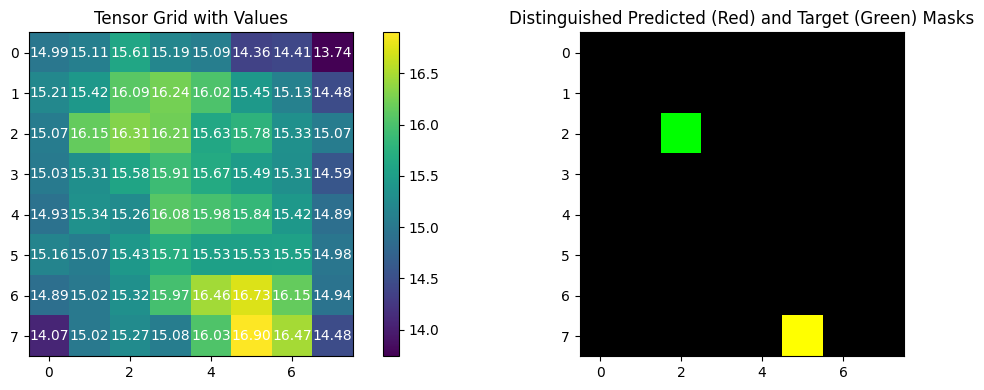

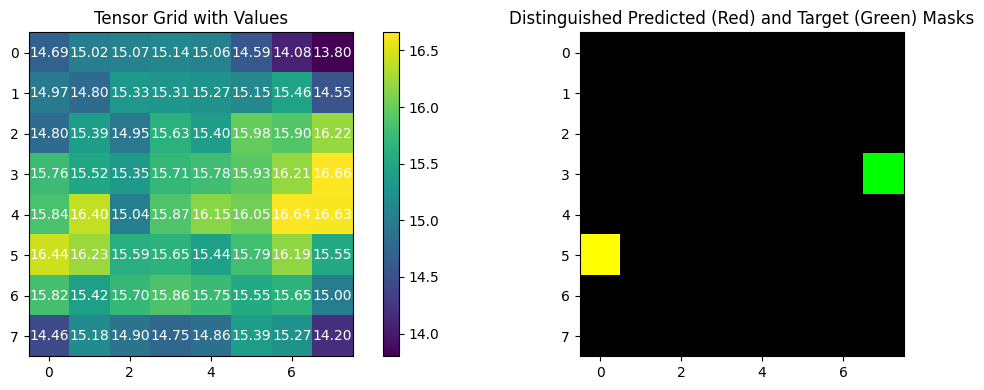

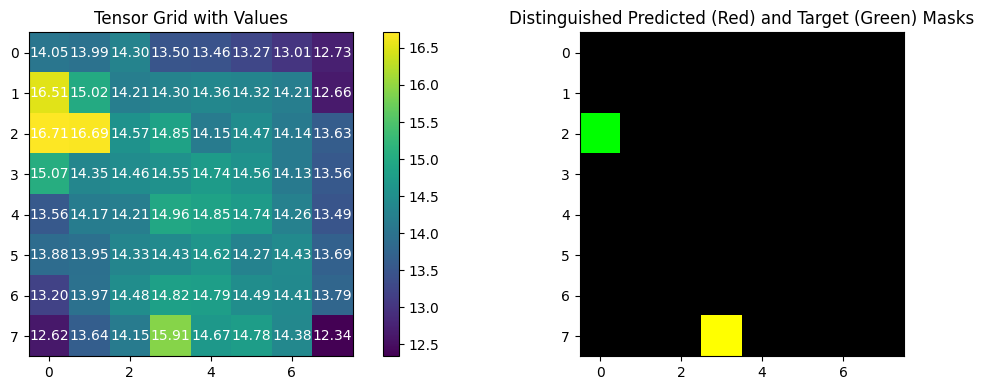

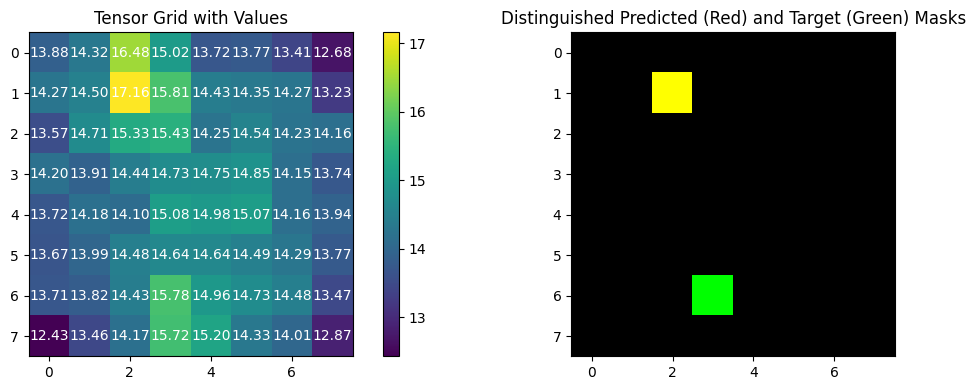

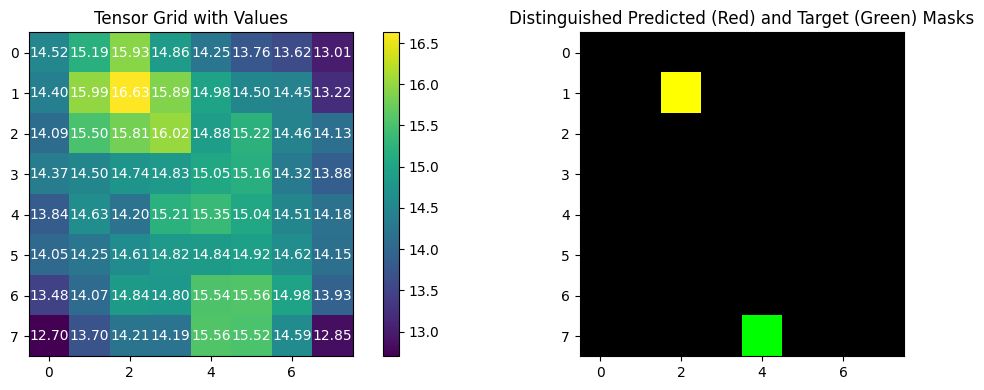

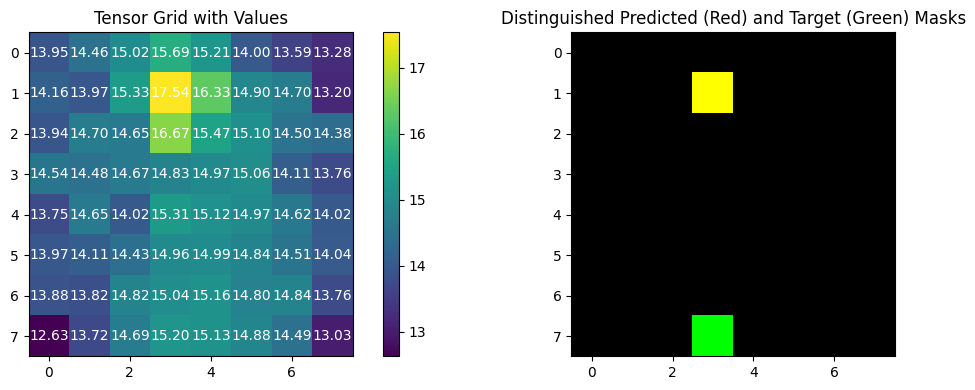

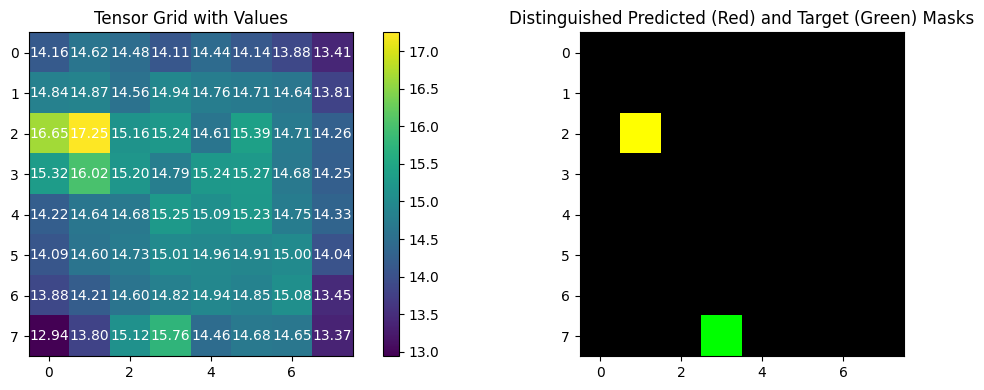

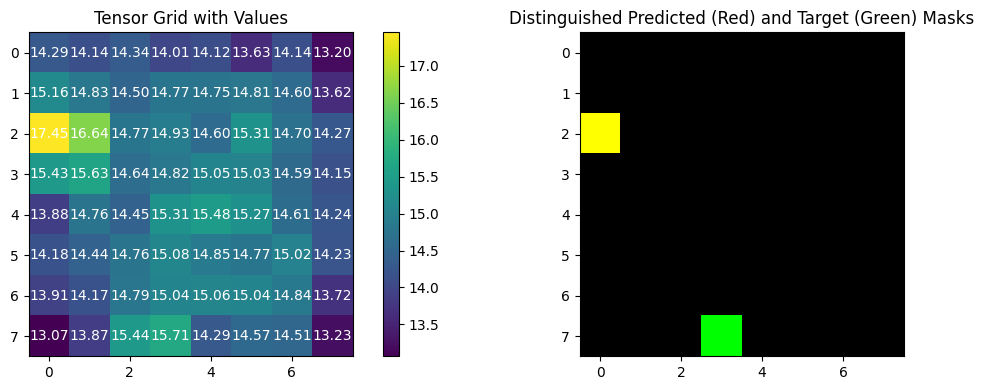

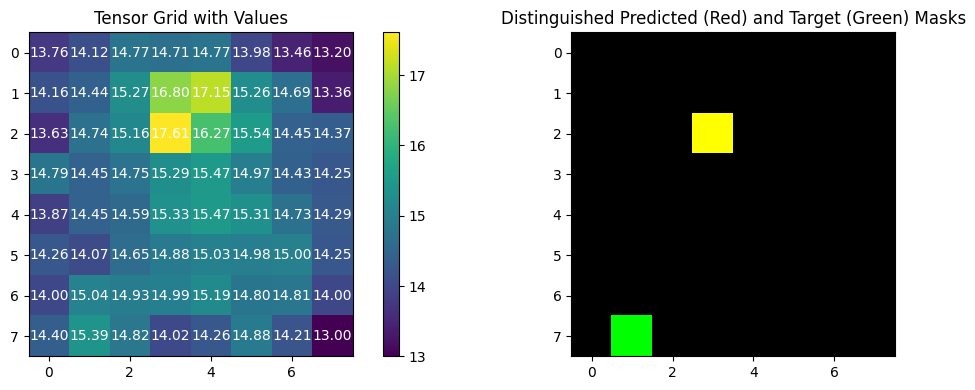

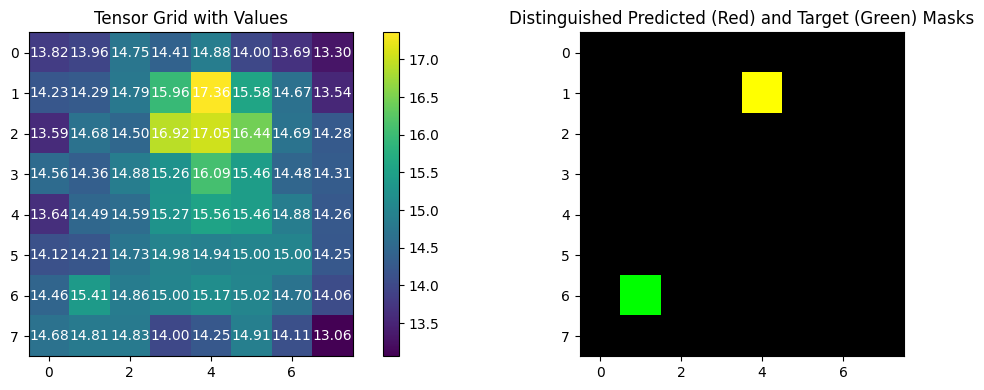

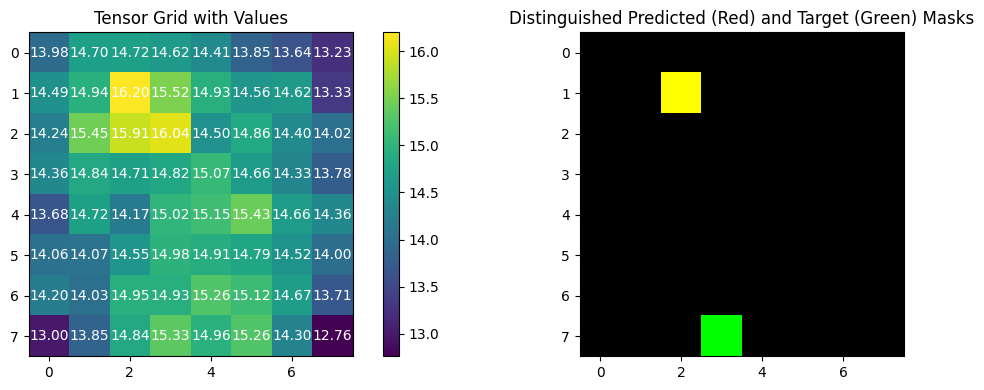

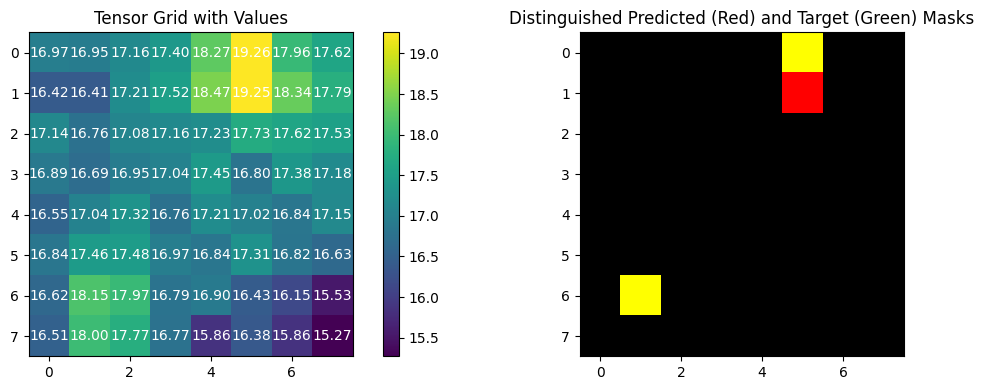

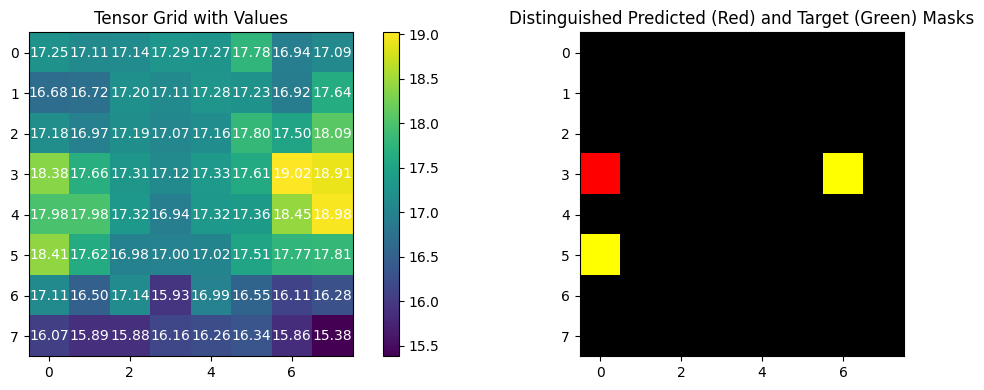

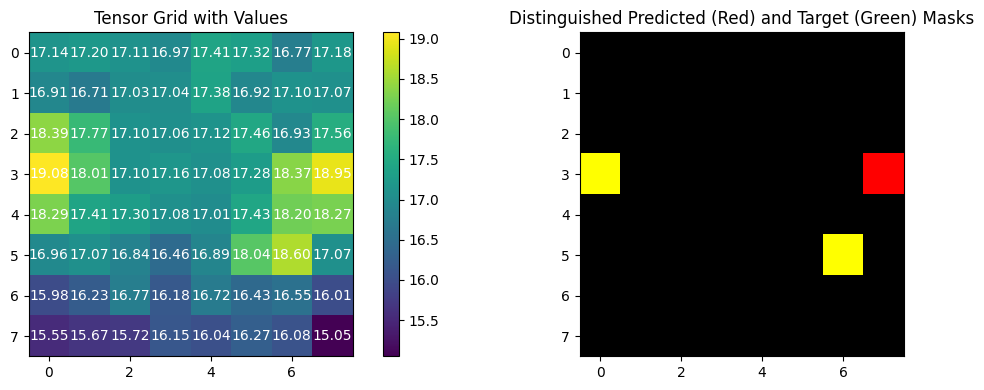

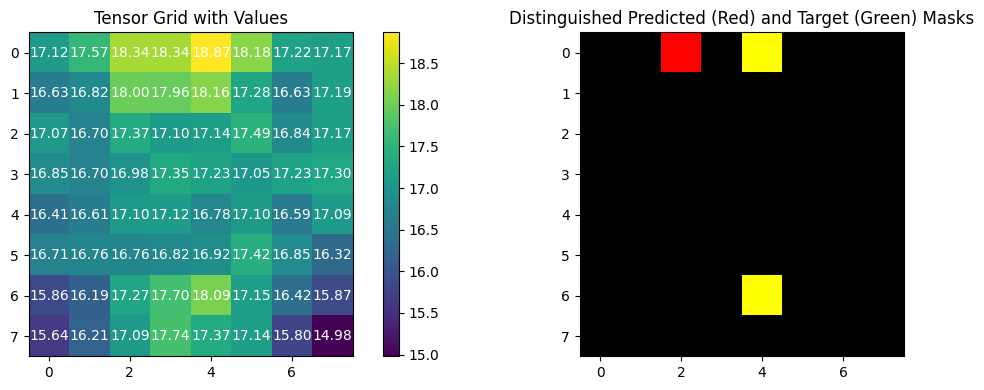

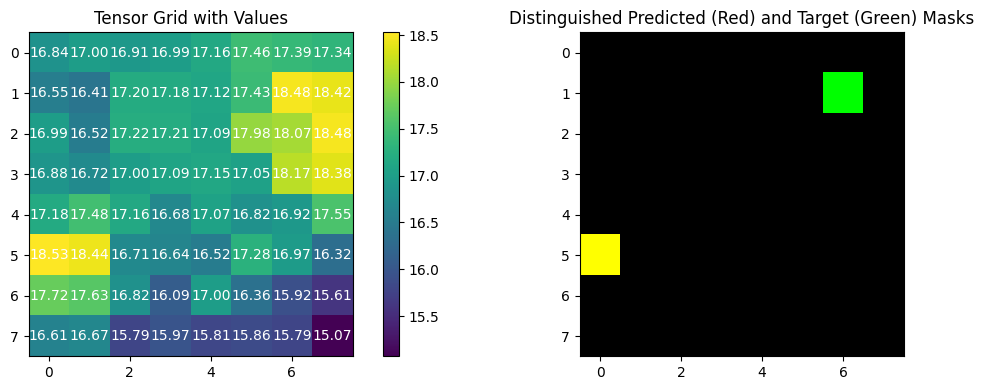

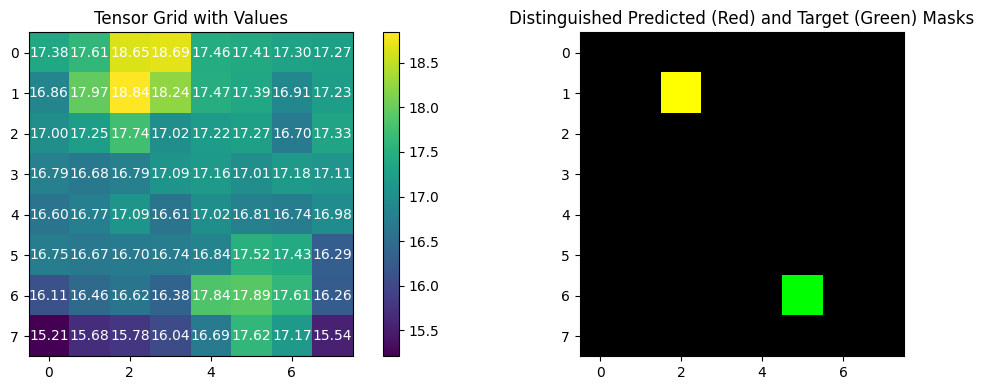

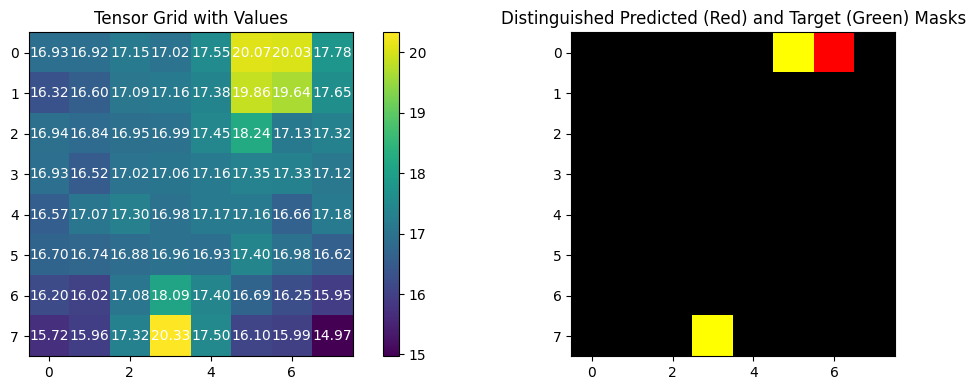

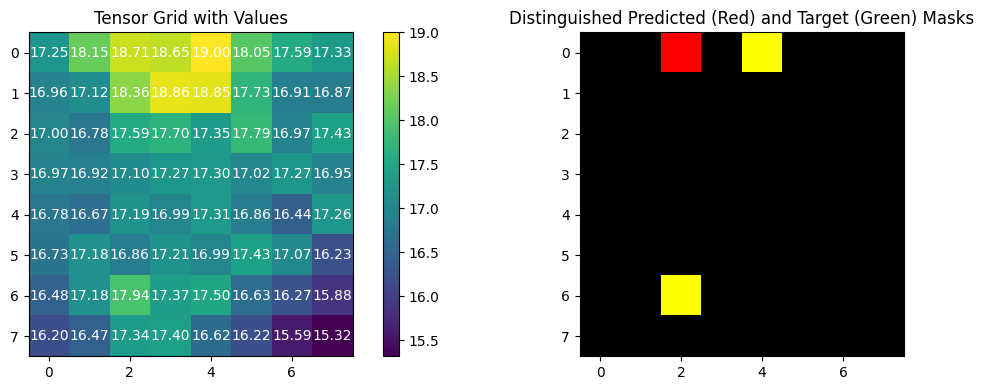

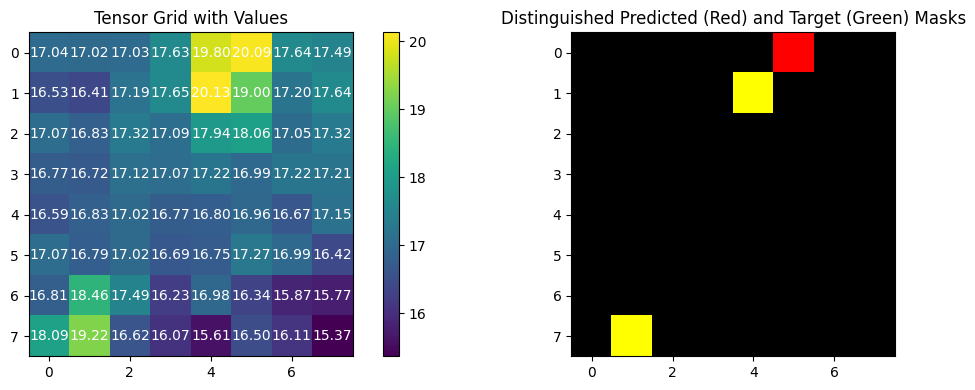

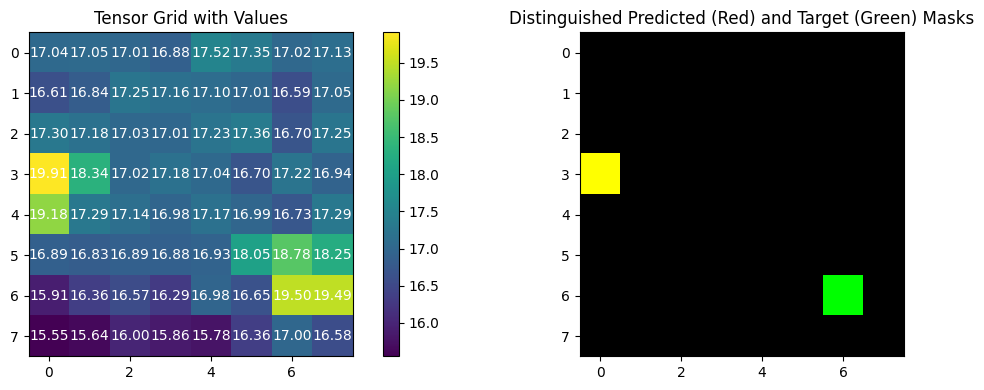

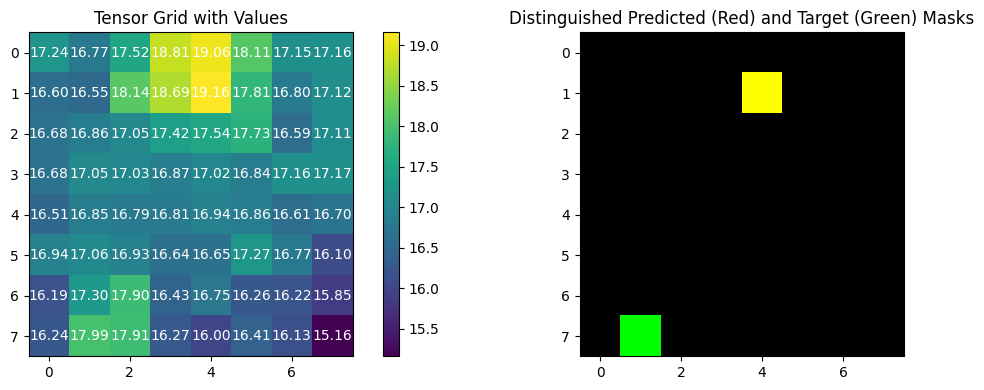

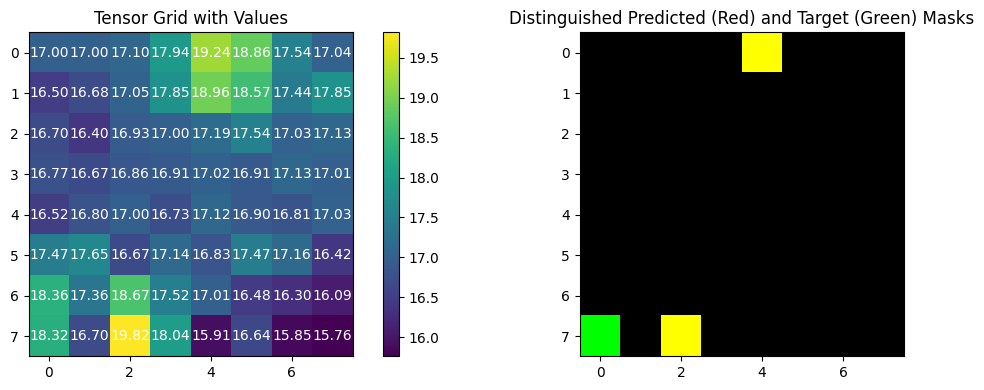

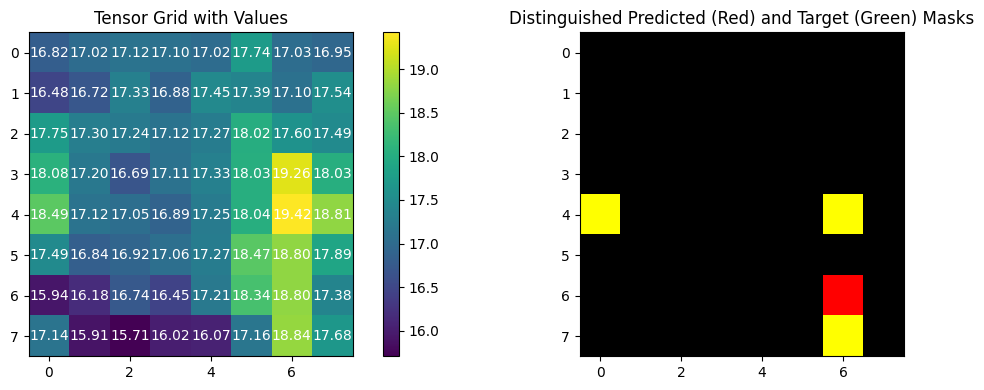

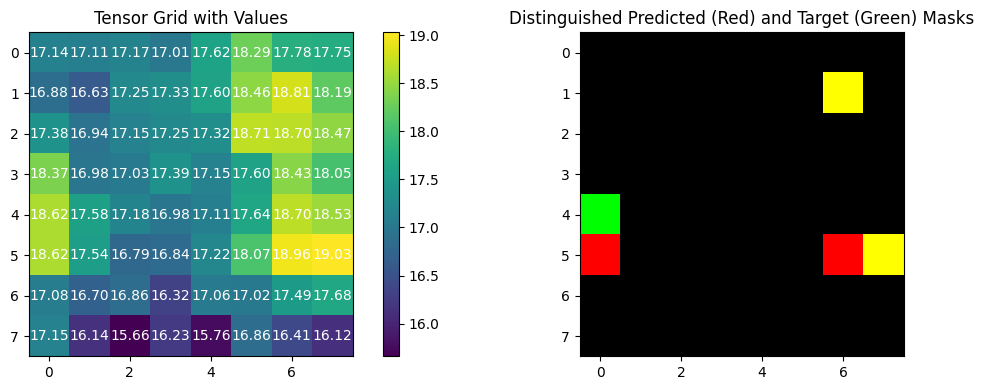

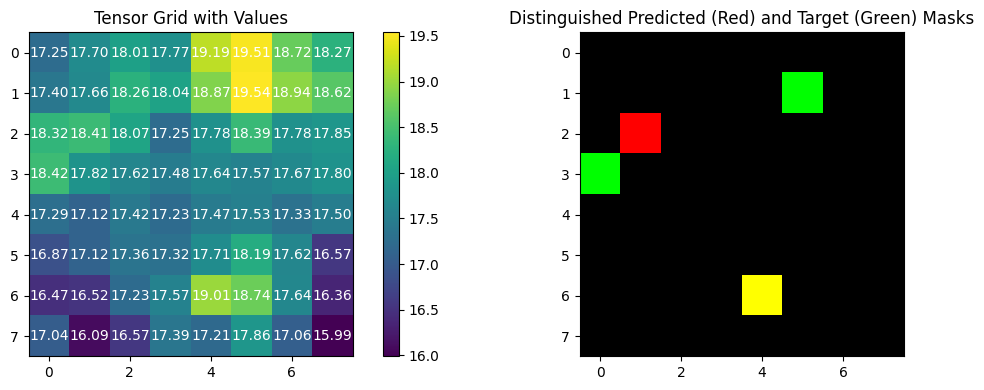

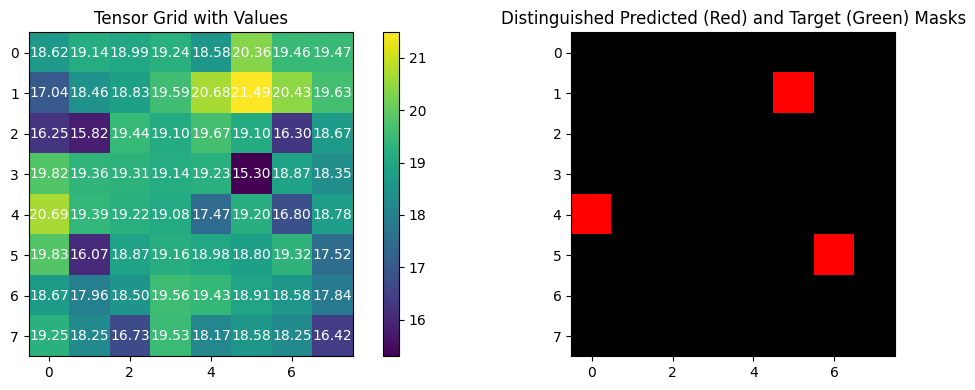

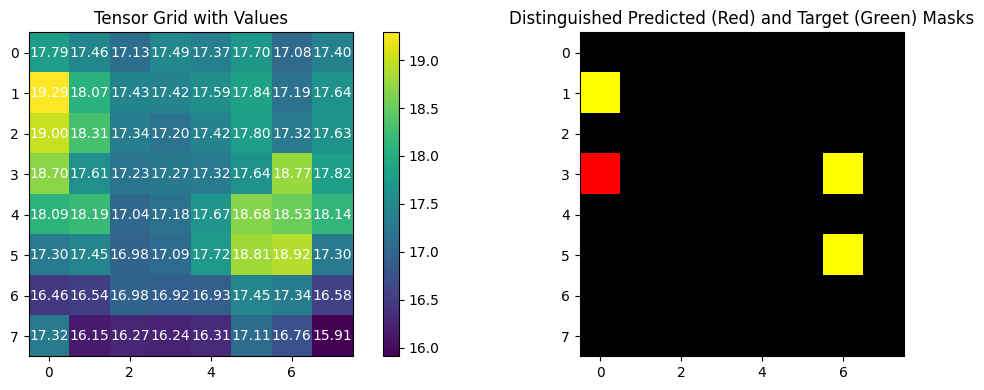

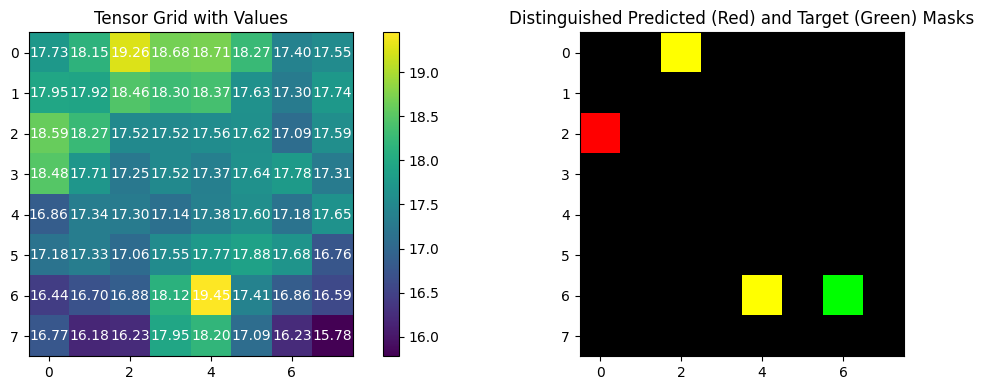

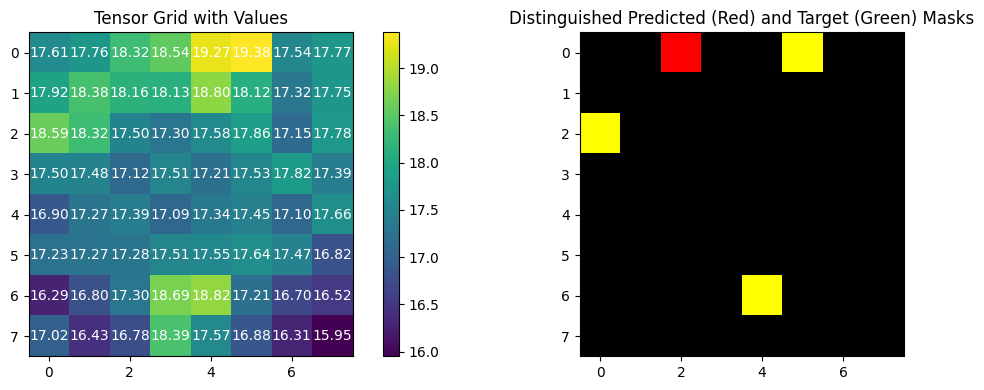

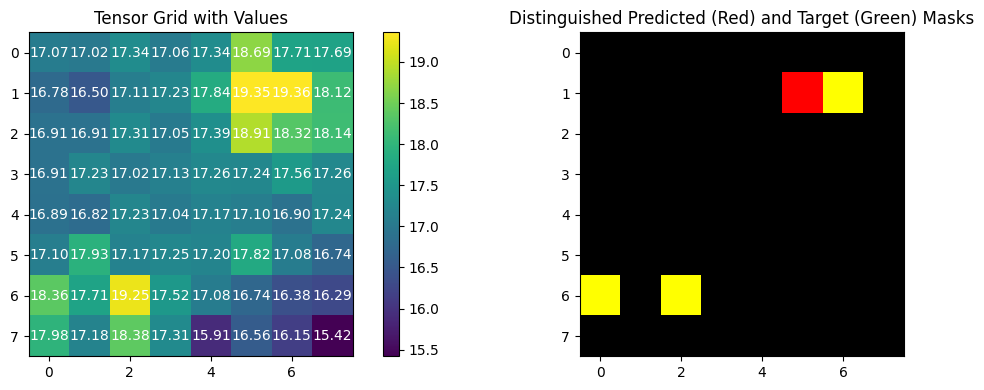

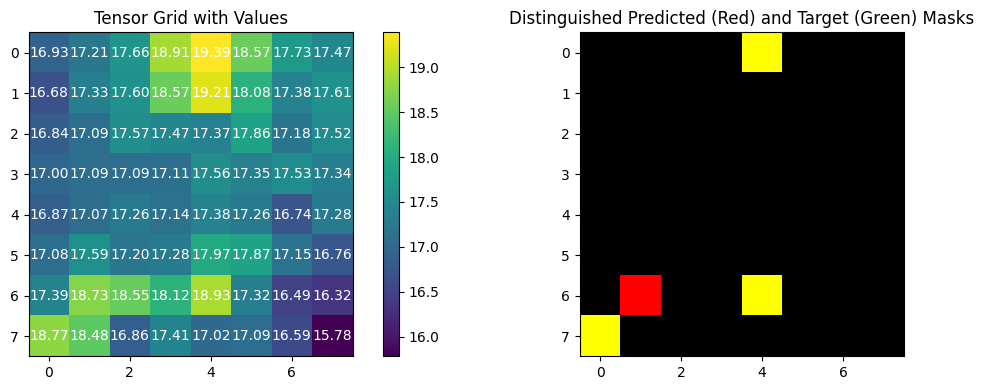

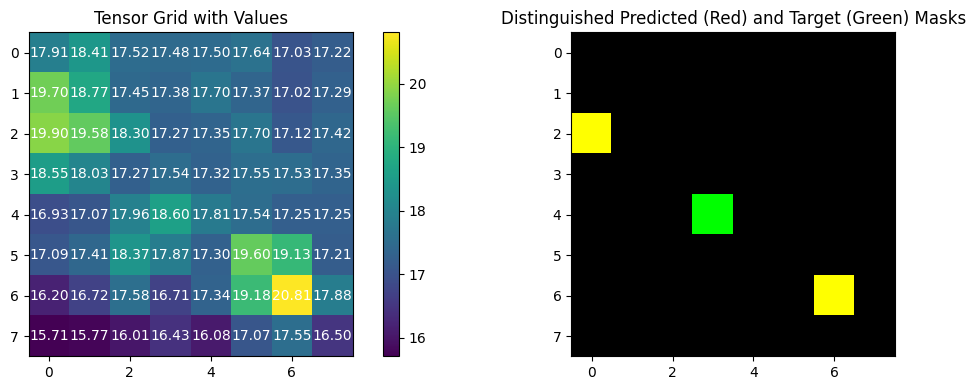

In [55]:
for sample in misclassified_samples[a:b]:
    plot_grid(sample)